Notizen:

MC Dropout mit nur epistemic Uncertainty: overconfident, trainiert mit MSE

MC Dropout mit aleatoric(tau, lengthscale) (homoscedastic) und epistemic: underconfident, erst trainiert mit MSE und dann NLL, manuelle Anpassung von tau, dann besser, 500 Samples bricht Kernel immer ab?!

MC Dropout heteroscedastic beste Variante?! Network sagt mean und variance pro input voraus, implementiert, von R² Score am schlechtesten, etwas zu unsicher

Optuna: mein Gefühl, manchmal zu schnell in einem loss Valley, dann bleibt es dort bzw. sucht in diesem nach guten kombinationen, globales Optimum erreichbar?!

Necessary imports

In [ ]:
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score

# check the computer name and set the path accordingly
if os.environ['COMPUTERNAME'] == 'FYNN':            # name of surface PC
    sys.path.append(r'C:\Users\Surface\Masterarbeit')
elif os.environ['COMPUTERNAME'] == 'FYNNS-PC':      # desktop name
    sys.path.append(r'C:\Users\test\Masterarbeit')
    
else:
    raise ValueError("Unbekannter Computername: " + os.environ['COMPUTERNAME'])


Load, Transform and Split the data

In [ ]:
import data_prep

#load and transform the data, split it into training, validation, and test sets
# the split ratio is 60% training, 20% validation, and 20%
# return the feature names for later use
X_train, X_val, X_test, y_train, y_val, y_test, feature_names = data_prep.load_tranform_and_split_data('C1_V01_delta_kan', split_ratio=(0.6, 0.2, 0.2))

# convert the data to PyTorch tensors
# and add an extra dimension for the target variable
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
X_test_tensor = torch.from_numpy(X_test).float() 
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1) # Add extra dimension for compatibility
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)
print(X_train_tensor.shape, X_val_tensor.shape, X_test_tensor.shape)
print(feature_names)

torch.Size([31206, 37]) torch.Size([10402, 37]) torch.Size([10403, 37])
Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')


Hyperparameter Search with Optuna for network architecture

https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py#L93

https://www.youtube.com/watch?v=P6NwZVl8ttc


In [ ]:
import optuna
import NN_model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def objective(trial):
 
    # hyperparameter for sampling with Optuna
    n_layer = trial.suggest_int("n_layer", 2, 4)  # number of hidden layers
    n_neurons = trial.suggest_int("n_neurons", 32, 256, step=32)  # number of neurons in each hidden layer
    do_rate = trial.suggest_float("do_rate", 0.05, 0.5)     # dropout rate 
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)    # learning rate
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256]) 
    
    # decay factor for the number of neurons in each layer
    # e.g. if n_neurons = 256 and n_layer = 3
    # then the hidden_dims will be [256, 128, 64]
    decay = 0.5
    # this creates a list of integers representing the number of neurons in each hidden layer
    hidden_dims = [int(n_neurons * decay**i) for i in range(n_layer)]
    print(f"Hidden dimensions: {hidden_dims}")
        
    # generate the model with the sampled hyperparameters
    # and move it to the device (GPU or CPU)
    model = NN_model.Custom_NN_Model(
        input_dim=X_train_tensor.shape[1],
        hidden_dims=hidden_dims,
        output_dim=1,
        do_rate=do_rate,
        loss_type = None
    ).to(device)

    # AdamW optimizer, where weight decay does not accumulate in the momentum nor variance.
    optimizer = torch.optim.AdamW(params = model.parameters(), lr = lr, weight_decay=0.0001)  

    # DataLoader for batching the data
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # integrate early stopping
    patience = 20  # number of epochs with no improvement after which training will be stopped
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # training the model
    for epoch in range(epochs):
        model.train()
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)  # Move data to the device (GPU or CPU)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = torch.nn.functional.mse_loss(output, y_batch)
            loss.backward()
            optimizer.step()
            
        # validation loss calculation after each epoch
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_tensor)
            val_loss = torch.nn.functional.mse_loss(y_val_pred, y_val_tensor).item()
            
        trial.report(val_loss, step=epoch)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            #print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Best Val Loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}, Best Val Loss: {best_val_loss:.4f}")
                break
    
    return val_loss


c:\Users\test\Masterarbeit\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Execute Optuna Study

In [15]:
from optuna.trial import TrialState

# define the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# number of epochs for training
epochs = 500

# create a study object for Optuna
study = optuna.create_study(
    #study_name="MC_Dropout_Optuna_Network_architecture",
    #storage="sqlite:///mc_dropout_study.db",                    # Use SQLite database to store the
    #load_if_exists=True,                                        # load the study if it already exists
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),                       #TPE (Tree-structured Parzen Estimator) sampler by default
    pruner=optuna.pruners.MedianPruner(        
        n_startup_trials=10,                                    # Number of trials to run before pruning starts
        n_warmup_steps=5                                        # Number of warmup steps before pruning starts)
    )
)

# move the tensors to the device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

# optimize the objective function with Optuna
# timeout=None means no time limit for the optimization, all trials will be run
study.optimize(objective, n_trials=100, timeout=None, n_jobs=1, show_progress_bar=True)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-07-10 16:33:25,593] A new study created in memory with name: no-name-07bc177b-4e01-42d4-8a7c-08bf13bfeff0


Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden dimensions: [224, 112, 56]


Best trial: 0. Best value: 9.76357:   1%|          | 1/100 [04:27<7:21:22, 267.50s/it]

Early stopping at epoch 192, Best Val Loss: 9.5110
[I 2025-07-10 16:37:53,082] Trial 0 finished with value: 9.763571739196777 and parameters: {'n_layer': 3, 'n_neurons': 224, 'do_rate': 0.3327435232208362, 'lr': 0.003107840481541976, 'batch_size': 64}. Best is trial 0 with value: 9.763571739196777.
Hidden dimensions: [64, 32, 16, 8]


Best trial: 0. Best value: 9.76357:   2%|▏         | 2/100 [05:05<3:36:13, 132.38s/it]

Early stopping at epoch 62, Best Val Loss: 46.1953
[I 2025-07-10 16:38:30,897] Trial 1 finished with value: 49.21614074707031 and parameters: {'n_layer': 4, 'n_neurons': 64, 'do_rate': 0.08927887046260813, 'lr': 0.00020352781146411206, 'batch_size': 256}. Best is trial 0 with value: 9.763571739196777.
Hidden dimensions: [32, 16, 8, 4]


Best trial: 0. Best value: 9.76357:   3%|▎         | 3/100 [08:51<4:43:25, 175.31s/it]

Early stopping at epoch 401, Best Val Loss: 478.6981
[I 2025-07-10 16:42:17,283] Trial 2 finished with value: 482.8465576171875 and parameters: {'n_layer': 4, 'n_neurons': 32, 'do_rate': 0.34773843797821874, 'lr': 0.0002913179991663791, 'batch_size': 256}. Best is trial 0 with value: 9.763571739196777.
Hidden dimensions: [256, 128]


Best trial: 0. Best value: 9.76357:   4%|▍         | 4/100 [09:26<3:11:28, 119.68s/it]

Early stopping at epoch 71, Best Val Loss: 17.4485
[I 2025-07-10 16:42:51,679] Trial 3 finished with value: 18.04728126525879 and parameters: {'n_layer': 2, 'n_neurons': 256, 'do_rate': 0.4101368508982036, 'lr': 0.0013561628558827383, 'batch_size': 256}. Best is trial 0 with value: 9.763571739196777.
Hidden dimensions: [192, 96]


Best trial: 0. Best value: 9.76357:   5%|▌         | 5/100 [11:54<3:26:08, 130.19s/it]

Early stopping at epoch 306, Best Val Loss: 9.6458
[I 2025-07-10 16:45:20,514] Trial 4 finished with value: 10.16660213470459 and parameters: {'n_layer': 2, 'n_neurons': 192, 'do_rate': 0.3544231448753933, 'lr': 0.006341584681459852, 'batch_size': 256}. Best is trial 0 with value: 9.763571739196777.
Hidden dimensions: [96, 48, 24]


Best trial: 0. Best value: 9.76357:   6%|▌         | 6/100 [13:48<3:15:18, 124.67s/it]

Early stopping at epoch 211, Best Val Loss: 10.5737
[I 2025-07-10 16:47:14,461] Trial 5 finished with value: 12.513741493225098 and parameters: {'n_layer': 3, 'n_neurons': 96, 'do_rate': 0.22622303307348984, 'lr': 0.0027090803404824448, 'batch_size': 256}. Best is trial 0 with value: 9.763571739196777.
Hidden dimensions: [64, 32, 16, 8]


Best trial: 0. Best value: 9.76357:   7%|▋         | 7/100 [15:17<2:55:02, 112.93s/it]

Early stopping at epoch 151, Best Val Loss: 114.1525
[I 2025-07-10 16:48:43,225] Trial 6 finished with value: 132.5817108154297 and parameters: {'n_layer': 4, 'n_neurons': 64, 'do_rate': 0.466698892815624, 'lr': 0.0007105291480501569, 'batch_size': 256}. Best is trial 0 with value: 9.763571739196777.
Hidden dimensions: [64, 32, 16, 8]


Best trial: 7. Best value: 8.9071:   8%|▊         | 8/100 [21:10<4:50:18, 189.33s/it] 

Early stopping at epoch 219, Best Val Loss: 8.6576
[I 2025-07-10 16:54:36,143] Trial 7 finished with value: 8.90710163116455 and parameters: {'n_layer': 4, 'n_neurons': 64, 'do_rate': 0.05490107256731739, 'lr': 0.002553577656282978, 'batch_size': 64}. Best is trial 7 with value: 8.90710163116455.
Hidden dimensions: [192, 96, 48]


Best trial: 7. Best value: 8.9071:   9%|▉         | 9/100 [21:39<3:31:16, 139.30s/it]

Early stopping at epoch 53, Best Val Loss: 15.8001
[I 2025-07-10 16:55:05,431] Trial 8 finished with value: 25.344898223876953 and parameters: {'n_layer': 3, 'n_neurons': 192, 'do_rate': 0.109755013743656, 'lr': 0.0052813978454280056, 'batch_size': 256}. Best is trial 7 with value: 8.90710163116455.
Hidden dimensions: [224, 112, 56, 28]


Best trial: 7. Best value: 8.9071:  10%|█         | 10/100 [22:00<2:34:01, 102.68s/it]

Early stopping at epoch 36, Best Val Loss: 100.2928
[I 2025-07-10 16:55:26,114] Trial 9 finished with value: 192.6368865966797 and parameters: {'n_layer': 4, 'n_neurons': 224, 'do_rate': 0.4610450571701648, 'lr': 0.00031498737006358587, 'batch_size': 256}. Best is trial 7 with value: 8.90710163116455.
Hidden dimensions: [128, 64, 32, 16]


Best trial: 7. Best value: 8.9071:  11%|█         | 11/100 [24:28<2:52:56, 116.59s/it]

Early stopping at epoch 93, Best Val Loss: 11.9939
[I 2025-07-10 16:57:54,244] Trial 10 finished with value: 12.99985408782959 and parameters: {'n_layer': 4, 'n_neurons': 128, 'do_rate': 0.19807249797403736, 'lr': 0.0011105160342403662, 'batch_size': 64}. Best is trial 7 with value: 8.90710163116455.
Hidden dimensions: [160, 80, 40]


Best trial: 7. Best value: 8.9071:  12%|█▏        | 12/100 [29:08<4:04:00, 166.36s/it]

Early stopping at epoch 199, Best Val Loss: 9.4029
[I 2025-07-10 17:02:34,462] Trial 11 finished with value: 9.66580867767334 and parameters: {'n_layer': 3, 'n_neurons': 160, 'do_rate': 0.2770530217010935, 'lr': 0.003066361158224765, 'batch_size': 64}. Best is trial 7 with value: 8.90710163116455.
Hidden dimensions: [128, 64, 32]


Best trial: 7. Best value: 8.9071:  13%|█▎        | 13/100 [30:46<3:31:01, 145.54s/it]

Early stopping at epoch 118, Best Val Loss: 10.3932
[I 2025-07-10 17:04:12,067] Trial 12 finished with value: 10.93112850189209 and parameters: {'n_layer': 3, 'n_neurons': 128, 'do_rate': 0.21103930228360068, 'lr': 0.00912980565392161, 'batch_size': 128}. Best is trial 7 with value: 8.90710163116455.
Hidden dimensions: [160, 80, 40]


Best trial: 13. Best value: 8.48383:  14%|█▍        | 14/100 [36:30<4:54:40, 205.59s/it]

Early stopping at epoch 241, Best Val Loss: 8.4186
[I 2025-07-10 17:09:56,413] Trial 13 finished with value: 8.483834266662598 and parameters: {'n_layer': 3, 'n_neurons': 160, 'do_rate': 0.14218218501306715, 'lr': 0.0024602309060651768, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [96, 48]


Best trial: 13. Best value: 8.48383:  15%|█▌        | 15/100 [37:59<4:01:12, 170.26s/it]

[I 2025-07-10 17:11:24,817] Trial 14 pruned. 
Hidden dimensions: [32, 16, 8]


Best trial: 13. Best value: 8.48383:  16%|█▌        | 16/100 [38:09<2:50:50, 122.03s/it]

[I 2025-07-10 17:11:34,825] Trial 15 pruned. 
Hidden dimensions: [160, 80, 40]


Best trial: 13. Best value: 8.48383:  17%|█▋        | 17/100 [38:46<2:13:42, 96.65s/it] 

Early stopping at epoch 46, Best Val Loss: 16.9650
[I 2025-07-10 17:12:12,473] Trial 16 finished with value: 23.580141067504883 and parameters: {'n_layer': 3, 'n_neurons': 160, 'do_rate': 0.16118799032287226, 'lr': 0.0019053076511329223, 'batch_size': 128}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  18%|█▊        | 18/100 [42:16<2:58:40, 130.74s/it]

Early stopping at epoch 131, Best Val Loss: 9.1516
[I 2025-07-10 17:15:42,570] Trial 17 finished with value: 9.698763847351074 and parameters: {'n_layer': 4, 'n_neurons': 96, 'do_rate': 0.06154433127010737, 'lr': 0.00465811489175491, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [64, 32]


Best trial: 13. Best value: 8.48383:  19%|█▉        | 19/100 [43:03<2:22:16, 105.39s/it]

[I 2025-07-10 17:16:28,897] Trial 18 pruned. 
Hidden dimensions: [128, 64, 32]


Best trial: 13. Best value: 8.48383:  20%|██        | 20/100 [43:21<1:45:29, 79.12s/it] 

[I 2025-07-10 17:16:46,796] Trial 19 pruned. 
Hidden dimensions: [192, 96, 48, 24]


Best trial: 13. Best value: 8.48383:  21%|██        | 21/100 [44:13<1:33:27, 70.98s/it]

[I 2025-07-10 17:17:38,780] Trial 20 pruned. 
Hidden dimensions: [160, 80, 40]


Best trial: 13. Best value: 8.48383:  22%|██▏       | 22/100 [44:23<1:08:36, 52.78s/it]

[I 2025-07-10 17:17:49,129] Trial 21 pruned. 
Hidden dimensions: [160, 80, 40]


Best trial: 13. Best value: 8.48383:  23%|██▎       | 23/100 [44:32<50:41, 39.50s/it]  

[I 2025-07-10 17:17:57,663] Trial 22 pruned. 
Hidden dimensions: [160, 80, 40]


Best trial: 13. Best value: 8.48383:  24%|██▍       | 24/100 [46:04<1:10:09, 55.39s/it]

[I 2025-07-10 17:19:30,107] Trial 23 pruned. 
Hidden dimensions: [128, 64, 32]


Best trial: 13. Best value: 8.48383:  25%|██▌       | 25/100 [46:13<51:40, 41.35s/it]  

[I 2025-07-10 17:19:38,698] Trial 24 pruned. 
Hidden dimensions: [224, 112]


Best trial: 13. Best value: 8.48383:  26%|██▌       | 26/100 [48:19<1:22:23, 66.81s/it]

[I 2025-07-10 17:21:44,919] Trial 25 pruned. 
Hidden dimensions: [192, 96, 48, 24]


Best trial: 13. Best value: 8.48383:  27%|██▋       | 27/100 [48:28<1:00:23, 49.63s/it]

[I 2025-07-10 17:21:54,477] Trial 26 pruned. 
Hidden dimensions: [96, 48, 24]


Best trial: 13. Best value: 8.48383:  28%|██▊       | 28/100 [48:58<52:15, 43.54s/it]  

Early stopping at epoch 36, Best Val Loss: 18.3194
[I 2025-07-10 17:22:23,806] Trial 27 finished with value: 21.194677352905273 and parameters: {'n_layer': 3, 'n_neurons': 96, 'do_rate': 0.1253892187632321, 'lr': 0.0016296165312043647, 'batch_size': 128}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [160, 80, 40]


Best trial: 13. Best value: 8.48383:  29%|██▉       | 29/100 [50:35<1:10:28, 59.56s/it]

Early stopping at epoch 70, Best Val Loss: 11.3686
[I 2025-07-10 17:24:00,740] Trial 28 finished with value: 11.718938827514648 and parameters: {'n_layer': 3, 'n_neurons': 160, 'do_rate': 0.08253556373277164, 'lr': 0.006683338165653631, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [256, 128, 64]


Best trial: 13. Best value: 8.48383:  30%|███       | 30/100 [50:44<52:04, 44.64s/it]  

[I 2025-07-10 17:24:10,554] Trial 29 pruned. 
Hidden dimensions: [192, 96, 48, 24]


Best trial: 13. Best value: 8.48383:  31%|███       | 31/100 [50:56<39:45, 34.57s/it]

[I 2025-07-10 17:24:21,635] Trial 30 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  32%|███▏      | 32/100 [54:31<1:40:34, 88.75s/it]

Early stopping at epoch 134, Best Val Loss: 9.1395
[I 2025-07-10 17:27:56,799] Trial 31 finished with value: 9.260013580322266 and parameters: {'n_layer': 4, 'n_neurons': 96, 'do_rate': 0.050503253361037365, 'lr': 0.004780762922525119, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [64, 32, 16, 8]


Best trial: 13. Best value: 8.48383:  33%|███▎      | 33/100 [54:40<1:12:33, 64.97s/it]

[I 2025-07-10 17:28:06,286] Trial 32 pruned. 
Hidden dimensions: [32, 16, 8, 4]


Best trial: 13. Best value: 8.48383:  34%|███▍      | 34/100 [54:50<53:08, 48.30s/it]  

[I 2025-07-10 17:28:15,707] Trial 33 pruned. 
Hidden dimensions: [64, 32, 16, 8]


Best trial: 13. Best value: 8.48383:  35%|███▌      | 35/100 [54:59<39:41, 36.64s/it]

[I 2025-07-10 17:28:25,146] Trial 34 pruned. 
Hidden dimensions: [96, 48, 24]


Best trial: 13. Best value: 8.48383:  36%|███▌      | 36/100 [55:07<30:00, 28.14s/it]

[I 2025-07-10 17:28:33,438] Trial 35 pruned. 
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  37%|███▋      | 37/100 [56:23<44:24, 42.29s/it]

[I 2025-07-10 17:29:48,762] Trial 36 pruned. 
Hidden dimensions: [32, 16]


Best trial: 13. Best value: 8.48383:  38%|███▊      | 38/100 [56:27<31:59, 30.96s/it]

[I 2025-07-10 17:29:53,252] Trial 37 pruned. 
Hidden dimensions: [224, 112, 56, 28]


Best trial: 13. Best value: 8.48383:  39%|███▉      | 39/100 [56:37<25:04, 24.66s/it]

[I 2025-07-10 17:30:03,239] Trial 38 pruned. 
Hidden dimensions: [96, 48, 24]


Best trial: 13. Best value: 8.48383:  40%|████      | 40/100 [57:06<25:52, 25.87s/it]

[I 2025-07-10 17:30:31,942] Trial 39 pruned. 
Hidden dimensions: [64, 32, 16, 8]


Best trial: 13. Best value: 8.48383:  41%|████      | 41/100 [57:16<20:47, 21.14s/it]

[I 2025-07-10 17:30:42,024] Trial 40 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  42%|████▏     | 42/100 [57:25<17:03, 17.64s/it]

[I 2025-07-10 17:30:51,511] Trial 41 pruned. 
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  43%|████▎     | 43/100 [1:01:23<1:19:22, 83.55s/it]

Early stopping at epoch 146, Best Val Loss: 9.3943
[I 2025-07-10 17:34:48,860] Trial 42 finished with value: 9.837752342224121 and parameters: {'n_layer': 4, 'n_neurons': 128, 'do_rate': 0.08149970361182311, 'lr': 0.0042470341539591824, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  44%|████▍     | 44/100 [1:01:34<57:47, 61.92s/it]  

[I 2025-07-10 17:35:00,297] Trial 43 pruned. 
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  45%|████▌     | 45/100 [1:01:38<40:41, 44.39s/it]

[I 2025-07-10 17:35:03,776] Trial 44 pruned. 
Hidden dimensions: [160, 80, 40, 20]


Best trial: 13. Best value: 8.48383:  46%|████▌     | 46/100 [1:06:57<1:54:05, 126.77s/it]

Early stopping at epoch 201, Best Val Loss: 8.7000
[I 2025-07-10 17:40:22,770] Trial 45 finished with value: 8.953618049621582 and parameters: {'n_layer': 4, 'n_neurons': 160, 'do_rate': 0.0694206534652986, 'lr': 0.0020206154910399443, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [160, 80, 40]


Best trial: 13. Best value: 8.48383:  47%|████▋     | 47/100 [1:07:08<1:21:21, 92.10s/it] 

[I 2025-07-10 17:40:33,991] Trial 46 pruned. 
Hidden dimensions: [192, 96, 48, 24]


Best trial: 13. Best value: 8.48383:  48%|████▊     | 48/100 [1:07:18<58:23, 67.37s/it]  

[I 2025-07-10 17:40:43,628] Trial 47 pruned. 
Hidden dimensions: [160, 80, 40, 20]


Best trial: 13. Best value: 8.48383:  49%|████▉     | 49/100 [1:07:21<41:01, 48.26s/it]

[I 2025-07-10 17:40:47,300] Trial 48 pruned. 
Hidden dimensions: [192, 96, 48]


Best trial: 13. Best value: 8.48383:  50%|█████     | 50/100 [1:08:04<38:49, 46.59s/it]

[I 2025-07-10 17:41:30,009] Trial 49 pruned. 
Hidden dimensions: [160, 80]


Best trial: 13. Best value: 8.48383:  51%|█████     | 51/100 [1:08:50<37:50, 46.34s/it]

[I 2025-07-10 17:42:15,751] Trial 50 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  52%|█████▏    | 52/100 [1:12:05<1:12:52, 91.10s/it]

Early stopping at epoch 122, Best Val Loss: 9.4624
[I 2025-07-10 17:45:31,290] Trial 51 finished with value: 10.10460090637207 and parameters: {'n_layer': 4, 'n_neurons': 96, 'do_rate': 0.09815936466198952, 'lr': 0.0038083593207017684, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  53%|█████▎    | 53/100 [1:16:06<1:46:33, 136.04s/it]

Early stopping at epoch 150, Best Val Loss: 9.1356
[I 2025-07-10 17:49:32,177] Trial 52 finished with value: 9.4656400680542 and parameters: {'n_layer': 4, 'n_neurons': 128, 'do_rate': 0.05257561064224124, 'lr': 0.005543905980551906, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  54%|█████▍    | 54/100 [1:16:16<1:15:12, 98.09s/it] 

[I 2025-07-10 17:49:41,744] Trial 53 pruned. 
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  55%|█████▌    | 55/100 [1:16:28<54:21, 72.48s/it]  

[I 2025-07-10 17:49:54,477] Trial 54 pruned. 
Hidden dimensions: [160, 80, 40]


Best trial: 13. Best value: 8.48383:  56%|█████▌    | 56/100 [1:17:23<49:10, 67.06s/it]

[I 2025-07-10 17:50:48,892] Trial 55 pruned. 
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  57%|█████▋    | 57/100 [1:18:23<46:40, 65.12s/it]

[I 2025-07-10 17:51:49,471] Trial 56 pruned. 
Hidden dimensions: [160, 80, 40]


Best trial: 13. Best value: 8.48383:  58%|█████▊    | 58/100 [1:18:32<33:41, 48.14s/it]

[I 2025-07-10 17:51:57,974] Trial 57 pruned. 
Hidden dimensions: [64, 32, 16]


Best trial: 13. Best value: 8.48383:  59%|█████▉    | 59/100 [1:18:58<28:26, 41.62s/it]

[I 2025-07-10 17:52:24,375] Trial 58 pruned. 
Hidden dimensions: [192, 96, 48, 24]


Best trial: 13. Best value: 8.48383:  60%|██████    | 60/100 [1:19:05<20:50, 31.26s/it]

[I 2025-07-10 17:52:31,472] Trial 59 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  61%|██████    | 61/100 [1:19:18<16:42, 25.71s/it]

[I 2025-07-10 17:52:44,237] Trial 60 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  62%|██████▏   | 62/100 [1:23:58<1:04:31, 101.89s/it]

Early stopping at epoch 176, Best Val Loss: 9.0261
[I 2025-07-10 17:57:23,898] Trial 61 finished with value: 9.318634033203125 and parameters: {'n_layer': 4, 'n_neurons': 96, 'do_rate': 0.07005801650537088, 'lr': 0.00430370482777337, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  63%|██████▎   | 63/100 [1:27:39<1:24:58, 137.80s/it]

Early stopping at epoch 139, Best Val Loss: 9.1893
[I 2025-07-10 18:01:05,492] Trial 62 finished with value: 9.911477088928223 and parameters: {'n_layer': 4, 'n_neurons': 128, 'do_rate': 0.07323540331731229, 'lr': 0.00393165820907292, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [160, 80, 40, 20]


Best trial: 13. Best value: 8.48383:  64%|██████▍   | 64/100 [1:27:49<59:35, 99.32s/it]   

[I 2025-07-10 18:01:15,006] Trial 63 pruned. 
Hidden dimensions: [32, 16, 8, 4]


Best trial: 13. Best value: 8.48383:  65%|██████▌   | 65/100 [1:27:58<42:13, 72.39s/it]

[I 2025-07-10 18:01:24,558] Trial 64 pruned. 
Hidden dimensions: [64, 32, 16, 8]


Best trial: 13. Best value: 8.48383:  66%|██████▌   | 66/100 [1:28:16<31:38, 55.85s/it]

[I 2025-07-10 18:01:41,807] Trial 65 pruned. 
Hidden dimensions: [96, 48, 24]


Best trial: 13. Best value: 8.48383:  67%|██████▋   | 67/100 [1:29:03<29:15, 53.19s/it]

[I 2025-07-10 18:02:28,797] Trial 66 pruned. 
Hidden dimensions: [160, 80, 40, 20]


Best trial: 13. Best value: 8.48383:  68%|██████▊   | 68/100 [1:29:12<21:23, 40.09s/it]

[I 2025-07-10 18:02:38,338] Trial 67 pruned. 
Hidden dimensions: [128, 64, 32]


Best trial: 13. Best value: 8.48383:  69%|██████▉   | 69/100 [1:30:47<29:08, 56.40s/it]

[I 2025-07-10 18:04:12,770] Trial 68 pruned. 
Hidden dimensions: [64, 32, 16, 8]


Best trial: 13. Best value: 8.48383:  70%|███████   | 70/100 [1:32:36<36:11, 72.38s/it]

Early stopping at epoch 68, Best Val Loss: 11.7325
[I 2025-07-10 18:06:02,451] Trial 69 finished with value: 12.36947250366211 and parameters: {'n_layer': 4, 'n_neurons': 64, 'do_rate': 0.11895347985435008, 'lr': 0.007801920975954875, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  71%|███████   | 71/100 [1:32:43<25:24, 52.58s/it]

[I 2025-07-10 18:06:08,809] Trial 70 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  72%|███████▏  | 72/100 [1:37:29<57:13, 122.64s/it]

Early stopping at epoch 180, Best Val Loss: 8.7526
[I 2025-07-10 18:10:54,926] Trial 71 finished with value: 9.098934173583984 and parameters: {'n_layer': 4, 'n_neurons': 96, 'do_rate': 0.06241669797220716, 'lr': 0.004561207834048388, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  73%|███████▎  | 73/100 [1:37:38<39:54, 88.70s/it] 

[I 2025-07-10 18:11:04,443] Trial 72 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  74%|███████▍  | 74/100 [1:42:44<1:06:39, 153.84s/it]

Early stopping at epoch 193, Best Val Loss: 8.6606
[I 2025-07-10 18:16:10,271] Trial 73 finished with value: 8.736711502075195 and parameters: {'n_layer': 4, 'n_neurons': 96, 'do_rate': 0.06315319580676537, 'lr': 0.0034755303617822015, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [64, 32, 16, 8]


Best trial: 13. Best value: 8.48383:  75%|███████▌  | 75/100 [1:46:13<1:10:55, 170.23s/it]

[I 2025-07-10 18:19:38,745] Trial 74 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  76%|███████▌  | 76/100 [1:49:12<1:09:10, 172.94s/it]

[I 2025-07-10 18:22:38,007] Trial 75 pruned. 
Hidden dimensions: [64, 32, 16, 8]


Best trial: 13. Best value: 8.48383:  77%|███████▋  | 77/100 [1:51:31<1:02:26, 162.91s/it]

Early stopping at epoch 88, Best Val Loss: 10.1344
[I 2025-07-10 18:24:57,520] Trial 76 finished with value: 10.99487590789795 and parameters: {'n_layer': 4, 'n_neurons': 64, 'do_rate': 0.08144935984628726, 'lr': 0.00551847867897167, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  78%|███████▊  | 78/100 [1:56:24<1:13:59, 201.81s/it]

Early stopping at epoch 184, Best Val Loss: 8.6859
[I 2025-07-10 18:29:50,083] Trial 77 finished with value: 8.730438232421875 and parameters: {'n_layer': 4, 'n_neurons': 96, 'do_rate': 0.050314710669982325, 'lr': 0.004634951104385174, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  79%|███████▉  | 79/100 [1:56:45<51:36, 147.47s/it]  

[I 2025-07-10 18:30:10,759] Trial 78 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  80%|████████  | 80/100 [1:56:48<34:45, 104.28s/it]

[I 2025-07-10 18:30:14,262] Trial 79 pruned. 
Hidden dimensions: [64, 32, 16, 8]


Best trial: 13. Best value: 8.48383:  81%|████████  | 81/100 [1:56:58<24:00, 75.84s/it] 

[I 2025-07-10 18:30:23,745] Trial 80 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  82%|████████▏ | 82/100 [1:57:07<16:46, 55.92s/it]

[I 2025-07-10 18:30:33,197] Trial 81 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  83%|████████▎ | 83/100 [1:57:17<11:53, 41.99s/it]

[I 2025-07-10 18:30:42,678] Trial 82 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  84%|████████▍ | 84/100 [1:57:28<08:43, 32.72s/it]

[I 2025-07-10 18:30:53,778] Trial 83 pruned. 
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  85%|████████▌ | 85/100 [2:01:41<24:44, 98.97s/it]

Early stopping at epoch 160, Best Val Loss: 9.1826
[I 2025-07-10 18:35:07,330] Trial 84 finished with value: 9.624985694885254 and parameters: {'n_layer': 4, 'n_neurons': 128, 'do_rate': 0.07623397749878878, 'lr': 0.004175683467875643, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  86%|████████▌ | 86/100 [2:01:51<16:49, 72.14s/it]

[I 2025-07-10 18:35:16,870] Trial 85 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  87%|████████▋ | 87/100 [2:02:32<13:38, 62.96s/it]

[I 2025-07-10 18:35:58,403] Trial 86 pruned. 
Hidden dimensions: [64, 32, 16, 8]


Best trial: 13. Best value: 8.48383:  88%|████████▊ | 88/100 [2:02:42<09:22, 46.91s/it]

[I 2025-07-10 18:36:07,852] Trial 87 pruned. 
Hidden dimensions: [32, 16, 8, 4]


Best trial: 13. Best value: 8.48383:  89%|████████▉ | 89/100 [2:02:51<06:32, 35.68s/it]

[I 2025-07-10 18:36:17,352] Trial 88 pruned. 
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  90%|█████████ | 90/100 [2:03:01<04:38, 27.87s/it]

[I 2025-07-10 18:36:27,002] Trial 89 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  91%|█████████ | 91/100 [2:03:06<03:10, 21.16s/it]

[I 2025-07-10 18:36:32,504] Trial 90 pruned. 
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  92%|█████████▏| 92/100 [2:03:16<02:21, 17.68s/it]

[I 2025-07-10 18:36:42,069] Trial 91 pruned. 
Hidden dimensions: [160, 80, 40, 20]


Best trial: 13. Best value: 8.48383:  93%|█████████▎| 93/100 [2:03:26<01:46, 15.24s/it]

[I 2025-07-10 18:36:51,598] Trial 92 pruned. 
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  94%|█████████▍| 94/100 [2:03:37<01:24, 14.02s/it]

[I 2025-07-10 18:37:02,784] Trial 93 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  95%|█████████▌| 95/100 [2:03:48<01:05, 13.18s/it]

[I 2025-07-10 18:37:14,018] Trial 94 pruned. 
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  96%|█████████▌| 96/100 [2:06:21<03:40, 55.25s/it]

[I 2025-07-10 18:39:47,411] Trial 95 pruned. 
Hidden dimensions: [160, 80, 40, 20]


Best trial: 13. Best value: 8.48383:  97%|█████████▋| 97/100 [2:06:42<02:14, 44.88s/it]

[I 2025-07-10 18:40:08,098] Trial 96 pruned. 
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  98%|█████████▊| 98/100 [2:06:46<01:05, 32.54s/it]

[I 2025-07-10 18:40:11,849] Trial 97 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  99%|█████████▉| 99/100 [2:06:55<00:25, 25.65s/it]

[I 2025-07-10 18:40:21,412] Trial 98 pruned. 
Hidden dimensions: [64, 32, 16, 8]


Best trial: 13. Best value: 8.48383: 100%|██████████| 100/100 [2:07:32<00:00, 76.52s/it]

[I 2025-07-10 18:40:57,711] Trial 99 pruned. 
Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  69
  Number of complete trials:  31
Best trial:
  Value:  8.483834266662598
  Params: 
    n_layer: 3
    n_neurons: 160
    do_rate: 0.14218218501306715
    lr: 0.0024602309060651768
    batch_size: 64


In [ ]:
# selcet Device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move training and val data  to device
X_train_tensor = X_train_tensor.to(device)  
X_val_tensor = X_val_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
# Create model instance with best parameters and move to device
model_mse = NN_model.Custom_NN_Model(input_dim=X_train.shape[1], hidden_dims=[160, 80, 40], output_dim=1, do_rate=0.14).to(device)  # Create model instance and move to device
# Train the model with the best parameters
optimizer = torch.optim.AdamW(params=model_mse.parameters(), lr=0.0025, weight_decay=0.0001)  # Use AdamW optimizer with specified learning rate and weight decay
tr_model_mse = NN_model.train_model(model_mse, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, batch_size=64, n_epochs=1000, optimizer= optimizer, patience=20, loss_type='mse')

Using device: cuda
Epoch 1/1000, Train Loss: 974.3802, Val Loss: 36.1560, Best Val Loss: 36.1560
Epoch 3/1000, Train Loss: 238.3380, Val Loss: 31.6542, Best Val Loss: 31.6542
Epoch 4/1000, Train Loss: 236.1947, Val Loss: 27.3682, Best Val Loss: 27.3682
Epoch 9/1000, Train Loss: 219.7100, Val Loss: 25.4431, Best Val Loss: 25.4431
Epoch 10/1000, Train Loss: 219.2471, Val Loss: 25.4063, Best Val Loss: 25.4063
Epoch 14/1000, Train Loss: 201.9773, Val Loss: 22.1442, Best Val Loss: 22.1442
Epoch 16/1000, Train Loss: 193.1651, Val Loss: 19.8064, Best Val Loss: 19.8064
Epoch 29/1000, Train Loss: 142.9779, Val Loss: 18.4037, Best Val Loss: 18.4037
Epoch 31/1000, Train Loss: 135.7743, Val Loss: 18.0870, Best Val Loss: 18.0870
Epoch 38/1000, Train Loss: 119.2050, Val Loss: 18.0018, Best Val Loss: 18.0018
Epoch 39/1000, Train Loss: 115.7182, Val Loss: 15.6817, Best Val Loss: 15.6817
Epoch 42/1000, Train Loss: 110.7661, Val Loss: 15.1818, Best Val Loss: 15.1818
Epoch 43/1000, Train Loss: 107.7690, 

Inference on the Train and test data with only epistemic uncertainty

In [13]:
# inference with multiple forward passes
# keep the model in training mode to keep dropout active
tr_model_mse.train()
tr_model_mse.to('cpu')  # Ensure the model is on the correct device
X_tr = X_train_tensor.to('cpu')  # Ensure the input data is on the correct device
X_te = X_test_tensor.to('cpu')  # Ensure the test data is on the correct device
# Number of stochastic forward passes for MC Dropout
n_samples = 250

# Make multiple stochastic predictions (MC Dropout) on the train data
y_train_pred_mse = torch.stack([tr_model_mse(X_tr) for i in range(n_samples)]).detach().cpu().numpy() #list comprehension for the number of stochastic forward passes for MC Dropout

# Make multiple stochastic predictions (MC Dropout) on the test data
y_test_pred_mse = torch.stack([tr_model_mse(X_te) for i in range(n_samples)]).detach().cpu().numpy()

Plot the uncertainty interval for the NN with MC Dropout

R² on Train Data: 0.887
R² on Test Data: 0.859
empistemic variance 1.8158429861068726
(10403,) (10403,)
Mean of std: 1.2548892498016357 Std of std: 0.49101537466049194
Number of true values within the confidence interval: 7076 out of 10403
Coverage: 68.02%


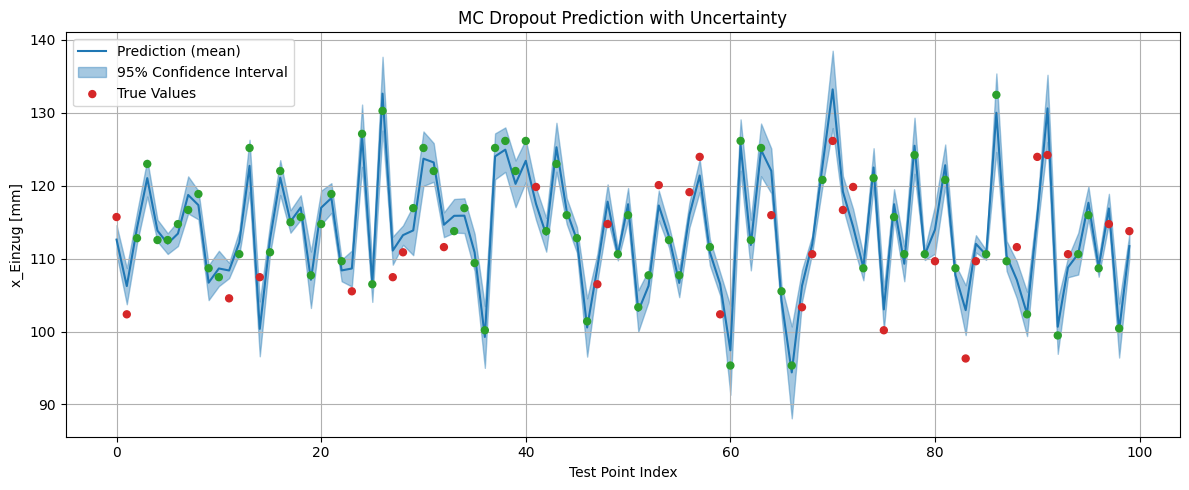

In [ ]:
#! handling the train data
# Calculate the mean and standard deviation of the predictions on the train data
y_train_pred_mean = y_train_pred_mse.mean(axis = 0)
y_train_Pred_std = y_train_pred_mse.std(axis = 0)

# Calculate R² score on the train data
r2_train = r2_score(y_train, y_train_pred_mean)
print(f"R² on Train Data: {r2_train:.3f}")

#! handling the test data
# Select a random subset of test data for visualization
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_te), num_points, replace=False)
random_indices.sort()

# Calculate the mean and standard deviation of the predictions on the test data
y_test_pred_mean = y_test_pred_mse.mean(axis = 0)
y_test_pred_std = y_test_pred_mse.std(axis = 0)

# Calculate R² score for the test data
r2_test = r2_score(y_test_tensor.cpu(), y_test_pred_mean)
print(f"R² on Test Data: {r2_test:.3f}")

# Assign descriptive variable names for MC Dropout mean and standard deviation
mc_mean = y_test_pred_mean.flatten()  # Predicted mean for each test point
mc_std = y_test_pred_std.flatten()    # Predicted standard deviation for uncertainty
print(f'empistemic variance {y_test_pred_mse.var(axis = 0).mean()}')
print(mc_mean.shape, mc_std.shape)
print(f'Mean of std: {mc_std.mean()} Std of std: {mc_std.std()}')

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
mc_lower_bound = mc_mean - 2 * mc_std
mc_upper_bound = mc_mean+ 2 * mc_std

# calculate the coverage of the confidence interval
in_interval = (y_test >= mc_lower_bound) & (y_test <= mc_upper_bound)
# number of true
counter = 0
# Print whether each true value is within the confidence interval
for i in in_interval:
    if i:
        counter += 1

print(f"Number of true values within the confidence interval: {counter} out of {len(in_interval)}")

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Check whether each true value from random indices lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval_rand_indi = (y_test[random_indices] >= mc_lower_bound[random_indices]) & (y_test[random_indices] <= mc_upper_bound[random_indices])
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval_rand_indi]

# Create the plot
plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)  # Create an index axis for plotting

# Plot the predicted mean
plt.plot(x_axis, mc_mean[random_indices], label="Prediction (mean)", color='tab:blue')

# Plot the confidence interval as a shaded region
plt.fill_between(x_axis, mc_lower_bound[random_indices], mc_upper_bound[random_indices], alpha=0.4,
                 color='tab:blue', label='95% Confidence Interval')

# Scatter plot of true values with color-coded points based on interval inclusion
plt.scatter(x_axis, y_test_tensor[random_indices].cpu().flatten(), label="True Values", c=colors, s=25, zorder=3)

# Final plot settings
plt.title("MC Dropout Prediction with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#! schlechte Coverage weil nur epistemic uncertainty is modeled?!
#! The model is trained with dropout, but the uncertainty estimation is not perfect.

Optuna Hyperparameter Search for legthscale and tau

In [ ]:
import optuna
def objective(trial):

    # number of stochastic forward passes for MC Dropout
    n_samples = 50  

    # fixed hyperparameters for simplicity
    hidden_dims = [160, 80, 40]  #! Use fixed hidden dimensions for simplicity
    lr = 0.0025  #! learning rate
    batch_size = 64  #! batch size
 
    # hyperparameter for sampling with Optuna
    tau = trial.suggest_float("tau", 0.01, 10.0, log=True)   
    lengthscale = trial.suggest_float("lengthscale", 1e-4, 1.0, log=True) 
    do_rate = trial.suggest_float("do_rate", 0.05, 0.3)     # dropout rate adjust range according to first run 

    N = X_train_tensor.shape[0]  # number of training samples
    # weight decay 
    weight_decay = lengthscale**2 * (1 - do_rate) / (2 * N * tau)  # Adjusted weight decay according to paper

    # generate the model with the sampled hyperparameters
    # and move it to the device (GPU or CPU)
    model = NN_model.Custom_NN_Model(
        input_dim=X_train_tensor.shape[1],
        hidden_dims= hidden_dims,
        output_dim=1,
        do_rate=do_rate
    ).to(device)

    # AdamW optimizer, where weight decay does not accumulate in the momentum nor variance.
    optimizer = torch.optim.AdamW(params = model.parameters(), lr = lr, weight_decay=weight_decay)  

    # DataLoader for batching the data
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # integrate early stopping
    patience = 20  # number of epochs with no improvement after which training will be stopped
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # training the model
    for epoch in range(epochs):
        model.train()
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)  # Move data to the device (GPU or CPU)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = torch.nn.functional.mse_loss(output, y_batch)
            loss.backward()
            optimizer.step()
            
        # validation loss calculation after each epoch
        model.train()  # Set model to training mode for MC Dropout predcition
        with torch.no_grad():
            y_val_preds = torch.stack(
                [model(X_val_tensor) for _ in range(n_samples)]
            )

            #mc_val_pred_mean = y_val_preds.mean(axis=0)
            #mc_val_pred_std = y_val_preds.std(axis=0)

            # compute the negative log liklihood
            ll_val_loss = (torch.logsumexp(-0.5 * tau * (y_val_tensor[None] - y_val_preds)**2, 0) - np.log(n_samples)
                            - 0.5 * np.log(2 * np.pi) - 0.5 * np.log(tau))
            nll_val_loss = - ll_val_loss.mean()
        

        # Early stopping check
        # If the validation loss is lower than the best validation loss, update the best validation loss
        if nll_val_loss < best_val_loss:
            best_val_loss = nll_val_loss
            epochs_no_improve = 0
            print(f"Epoch {epoch+1}/{epochs}, NLL Val Loss: {nll_val_loss:.4f}, Best NLL Val Loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break  # Early stopping

        trial.report(nll_val_loss, step=epoch)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
    return nll_val_loss


In [21]:
from optuna.trial import TrialState

# define the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# number of epochs for training
epochs = 200

# create a study object for Optuna
study = optuna.create_study(
    #study_name="MC_Dropout_Optuna_Network_architecture",
    #storage="sqlite:///mc_dropout_study.db",                    # Use SQLite database to store the
    #load_if_exists=True,                                        # load the study if it already exists
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),                       #TPE (Tree-structured Parzen Estimator) sampler by default
    pruner=optuna.pruners.MedianPruner(        
        n_startup_trials=10,                                    # Number of trials to run before pruning starts
        n_warmup_steps=5                                        # Number of warmup steps before pruning starts)
    )
)

# move the tensors to the device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

# optimize the objective function with Optuna
# timeout=None means no time limit for the optimization, all trials will be run
study.optimize(objective, n_trials=25, timeout=None, n_jobs=1, show_progress_bar=True)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-07-11 10:19:41,894] A new study created in memory with name: no-name-f90e4dd6-b682-4576-a217-8a606aee8ba8


Using device: cuda


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/200, NLL Val Loss: 5.6528, Best NLL Val Loss: 5.6528
Epoch 2/200, NLL Val Loss: 5.4767, Best NLL Val Loss: 5.4767
Epoch 5/200, NLL Val Loss: 5.4148, Best NLL Val Loss: 5.4148
Epoch 9/200, NLL Val Loss: 5.3375, Best NLL Val Loss: 5.3375
Epoch 10/200, NLL Val Loss: 5.2922, Best NLL Val Loss: 5.2922
Epoch 14/200, NLL Val Loss: 5.2057, Best NLL Val Loss: 5.2057
Epoch 15/200, NLL Val Loss: 5.1626, Best NLL Val Loss: 5.1626
Epoch 18/200, NLL Val Loss: 5.1118, Best NLL Val Loss: 5.1118
Epoch 19/200, NLL Val Loss: 5.0835, Best NLL Val Loss: 5.0835
Epoch 20/200, NLL Val Loss: 5.0739, Best NLL Val Loss: 5.0739
Epoch 21/200, NLL Val Loss: 5.0064, Best NLL Val Loss: 5.0064
Epoch 23/200, NLL Val Loss: 4.9737, Best NLL Val Loss: 4.9737
Epoch 25/200, NLL Val Loss: 4.9286, Best NLL Val Loss: 4.9286
Epoch 28/200, NLL Val Loss: 4.9123, Best NLL Val Loss: 4.9123
Epoch 30/200, NLL Val Loss: 4.8716, Best NLL Val Loss: 4.8716
Epoch 32/200, NLL Val Loss: 4.8626, Best NLL Val Loss: 4.8626
Epoch 34/200

Best trial: 0. Best value: 4.5944:   4%|▍         | 1/25 [03:44<1:29:48, 224.53s/it]

[I 2025-07-11 10:23:26,428] Trial 0 finished with value: 4.594402313232422 and parameters: {'tau': 4.028848995100415, 'lengthscale': 0.19375820350786246, 'do_rate': 0.18505529391812214}. Best is trial 0 with value: 4.594402313232422.
Epoch 1/200, NLL Val Loss: 1.5369, Best NLL Val Loss: 1.5369
Epoch 2/200, NLL Val Loss: 1.5301, Best NLL Val Loss: 1.5301
Epoch 5/200, NLL Val Loss: 1.5208, Best NLL Val Loss: 1.5208
Epoch 6/200, NLL Val Loss: 1.4815, Best NLL Val Loss: 1.4815
Epoch 7/200, NLL Val Loss: 1.4810, Best NLL Val Loss: 1.4810
Epoch 8/200, NLL Val Loss: 1.4632, Best NLL Val Loss: 1.4632
Epoch 9/200, NLL Val Loss: 1.4484, Best NLL Val Loss: 1.4484
Epoch 12/200, NLL Val Loss: 1.4388, Best NLL Val Loss: 1.4388
Epoch 15/200, NLL Val Loss: 1.4186, Best NLL Val Loss: 1.4186
Epoch 16/200, NLL Val Loss: 1.4183, Best NLL Val Loss: 1.4183
Epoch 17/200, NLL Val Loss: 1.4064, Best NLL Val Loss: 1.4064
Epoch 18/200, NLL Val Loss: 1.3892, Best NLL Val Loss: 1.3892
Epoch 20/200, NLL Val Loss: 1

Best trial: 1. Best value: 0.491974:   8%|▊         | 2/25 [09:34<1:54:18, 298.18s/it]

Epoch 200/200, NLL Val Loss: 0.4920, Best NLL Val Loss: 0.4920
[I 2025-07-11 10:29:16,157] Trial 1 finished with value: 0.4919743835926056 and parameters: {'tau': 0.13086626008049895, 'lengthscale': 0.009308758012522386, 'do_rate': 0.11180976120535775}. Best is trial 1 with value: 0.4919743835926056.
Epoch 1/200, NLL Val Loss: 4.4894, Best NLL Val Loss: 4.4894
Epoch 2/200, NLL Val Loss: 4.2178, Best NLL Val Loss: 4.2178
Epoch 3/200, NLL Val Loss: 4.1735, Best NLL Val Loss: 4.1735
Epoch 6/200, NLL Val Loss: 4.1420, Best NLL Val Loss: 4.1420
Epoch 7/200, NLL Val Loss: 4.1143, Best NLL Val Loss: 4.1143
Epoch 11/200, NLL Val Loss: 4.1033, Best NLL Val Loss: 4.1033
Epoch 12/200, NLL Val Loss: 4.0787, Best NLL Val Loss: 4.0787
Epoch 13/200, NLL Val Loss: 4.0739, Best NLL Val Loss: 4.0739
Epoch 16/200, NLL Val Loss: 3.9839, Best NLL Val Loss: 3.9839
Epoch 22/200, NLL Val Loss: 3.9612, Best NLL Val Loss: 3.9612
Epoch 23/200, NLL Val Loss: 3.9571, Best NLL Val Loss: 3.9571
Epoch 25/200, NLL Val

Best trial: 1. Best value: 0.491974:  12%|█▏        | 3/25 [14:10<1:45:37, 288.07s/it]

[I 2025-07-11 10:33:52,196] Trial 2 finished with value: 3.464400291442871 and parameters: {'tau': 1.8043828789901966, 'lengthscale': 0.04695274067038724, 'do_rate': 0.1036282525770282}. Best is trial 1 with value: 0.4919743835926056.
Epoch 1/200, NLL Val Loss: 0.5766, Best NLL Val Loss: 0.5766
Epoch 2/200, NLL Val Loss: 0.5052, Best NLL Val Loss: 0.5052
Epoch 4/200, NLL Val Loss: 0.4877, Best NLL Val Loss: 0.4877
Epoch 6/200, NLL Val Loss: 0.4597, Best NLL Val Loss: 0.4597
Epoch 9/200, NLL Val Loss: 0.4498, Best NLL Val Loss: 0.4498
Epoch 10/200, NLL Val Loss: 0.4403, Best NLL Val Loss: 0.4403
Epoch 11/200, NLL Val Loss: 0.4384, Best NLL Val Loss: 0.4384
Epoch 12/200, NLL Val Loss: 0.4337, Best NLL Val Loss: 0.4337
Epoch 14/200, NLL Val Loss: 0.4199, Best NLL Val Loss: 0.4199
Epoch 16/200, NLL Val Loss: 0.4009, Best NLL Val Loss: 0.4009
Epoch 20/200, NLL Val Loss: 0.3925, Best NLL Val Loss: 0.3925
Epoch 22/200, NLL Val Loss: 0.3920, Best NLL Val Loss: 0.3920
Epoch 24/200, NLL Val Loss

Best trial: 3. Best value: -0.107759:  16%|█▌        | 4/25 [19:59<1:49:19, 312.36s/it]

[I 2025-07-11 10:39:41,806] Trial 3 finished with value: -0.10775860399007797 and parameters: {'tau': 0.05980749200302506, 'lengthscale': 0.0007896787744162894, 'do_rate': 0.06529490273879592}. Best is trial 3 with value: -0.10775860399007797.
Epoch 1/200, NLL Val Loss: -0.2135, Best NLL Val Loss: -0.2135
Epoch 2/200, NLL Val Loss: -0.2192, Best NLL Val Loss: -0.2192
Epoch 3/200, NLL Val Loss: -0.2462, Best NLL Val Loss: -0.2462
Epoch 4/200, NLL Val Loss: -0.2695, Best NLL Val Loss: -0.2695
Epoch 5/200, NLL Val Loss: -0.2929, Best NLL Val Loss: -0.2929
Epoch 6/200, NLL Val Loss: -0.2988, Best NLL Val Loss: -0.2988
Epoch 7/200, NLL Val Loss: -0.3077, Best NLL Val Loss: -0.3077
Epoch 9/200, NLL Val Loss: -0.3755, Best NLL Val Loss: -0.3755
Epoch 10/200, NLL Val Loss: -0.3937, Best NLL Val Loss: -0.3937
Epoch 11/200, NLL Val Loss: -0.4102, Best NLL Val Loss: -0.4102
Epoch 12/200, NLL Val Loss: -0.4342, Best NLL Val Loss: -0.4342
Epoch 13/200, NLL Val Loss: -0.4384, Best NLL Val Loss: -0.4

Best trial: 4. Best value: -1.12674:  20%|██        | 5/25 [25:49<1:48:38, 325.93s/it] 

[I 2025-07-11 10:45:31,782] Trial 4 finished with value: -1.126744270324707 and parameters: {'tau': 0.01407150978875473, 'lengthscale': 0.011117994019885518, 'do_rate': 0.29097229085709}. Best is trial 4 with value: -1.126744270324707.
Epoch 1/200, NLL Val Loss: 4.3036, Best NLL Val Loss: 4.3036
Epoch 2/200, NLL Val Loss: 4.2869, Best NLL Val Loss: 4.2869
Epoch 3/200, NLL Val Loss: 4.2669, Best NLL Val Loss: 4.2669
Epoch 4/200, NLL Val Loss: 4.2187, Best NLL Val Loss: 4.2187
Epoch 7/200, NLL Val Loss: 4.2138, Best NLL Val Loss: 4.2138
Epoch 10/200, NLL Val Loss: 4.1987, Best NLL Val Loss: 4.1987
Epoch 12/200, NLL Val Loss: 4.1543, Best NLL Val Loss: 4.1543
Epoch 14/200, NLL Val Loss: 4.1472, Best NLL Val Loss: 4.1472
Epoch 15/200, NLL Val Loss: 4.0928, Best NLL Val Loss: 4.0928
Epoch 17/200, NLL Val Loss: 4.0864, Best NLL Val Loss: 4.0864
Epoch 19/200, NLL Val Loss: 4.0445, Best NLL Val Loss: 4.0445
Epoch 21/200, NLL Val Loss: 4.0250, Best NLL Val Loss: 4.0250
Epoch 23/200, NLL Val Los

Best trial: 4. Best value: -1.12674:  24%|██▍       | 6/25 [30:05<1:35:36, 301.90s/it]

[I 2025-07-11 10:49:47,034] Trial 5 finished with value: 3.3364195823669434 and parameters: {'tau': 1.5629948393139288, 'lengthscale': 0.00010447768391372156, 'do_rate': 0.14582661091153132}. Best is trial 4 with value: -1.126744270324707.
Epoch 1/200, NLL Val Loss: 3.3856, Best NLL Val Loss: 3.3856
Epoch 2/200, NLL Val Loss: 3.3441, Best NLL Val Loss: 3.3441
Epoch 3/200, NLL Val Loss: 3.2596, Best NLL Val Loss: 3.2596
Epoch 4/200, NLL Val Loss: 3.2548, Best NLL Val Loss: 3.2548
Epoch 5/200, NLL Val Loss: 3.2195, Best NLL Val Loss: 3.2195
Epoch 7/200, NLL Val Loss: 3.2130, Best NLL Val Loss: 3.2130
Epoch 8/200, NLL Val Loss: 3.1964, Best NLL Val Loss: 3.1964
Epoch 9/200, NLL Val Loss: 3.1605, Best NLL Val Loss: 3.1605
Epoch 11/200, NLL Val Loss: 3.1452, Best NLL Val Loss: 3.1452
Epoch 12/200, NLL Val Loss: 3.1439, Best NLL Val Loss: 3.1439
Epoch 13/200, NLL Val Loss: 3.1237, Best NLL Val Loss: 3.1237
Epoch 14/200, NLL Val Loss: 3.0971, Best NLL Val Loss: 3.0971
Epoch 15/200, NLL Val Lo

Best trial: 4. Best value: -1.12674:  28%|██▊       | 7/25 [35:40<1:33:53, 313.00s/it]

[I 2025-07-11 10:55:22,887] Trial 6 finished with value: 2.2544026374816895 and parameters: {'tau': 0.6563030839732096, 'lengthscale': 0.018220288085910162, 'do_rate': 0.1349507994657067}. Best is trial 4 with value: -1.126744270324707.
Epoch 1/200, NLL Val Loss: -0.7325, Best NLL Val Loss: -0.7325
Epoch 2/200, NLL Val Loss: -0.7987, Best NLL Val Loss: -0.7987
Epoch 5/200, NLL Val Loss: -0.8050, Best NLL Val Loss: -0.8050
Epoch 6/200, NLL Val Loss: -0.8226, Best NLL Val Loss: -0.8226
Epoch 8/200, NLL Val Loss: -0.8306, Best NLL Val Loss: -0.8306
Epoch 12/200, NLL Val Loss: -0.8325, Best NLL Val Loss: -0.8325
Epoch 15/200, NLL Val Loss: -0.8530, Best NLL Val Loss: -0.8530
Epoch 16/200, NLL Val Loss: -0.8560, Best NLL Val Loss: -0.8560
Epoch 19/200, NLL Val Loss: -0.8599, Best NLL Val Loss: -0.8599
Epoch 23/200, NLL Val Loss: -0.8638, Best NLL Val Loss: -0.8638
Epoch 24/200, NLL Val Loss: -0.8653, Best NLL Val Loss: -0.8653
Epoch 28/200, NLL Val Loss: -0.8734, Best NLL Val Loss: -0.8734


Best trial: 4. Best value: -1.12674:  32%|███▏      | 8/25 [41:31<1:32:02, 324.83s/it]

Epoch 200/200, NLL Val Loss: -1.0890, Best NLL Val Loss: -1.0890
[I 2025-07-11 11:01:13,046] Trial 7 finished with value: -1.0889614820480347 and parameters: {'tau': 0.014339278006731461, 'lengthscale': 0.006092742061301553, 'do_rate': 0.05601344567627954}. Best is trial 4 with value: -1.126744270324707.
Epoch 1/200, NLL Val Loss: 4.8106, Best NLL Val Loss: 4.8106
Epoch 2/200, NLL Val Loss: 4.5192, Best NLL Val Loss: 4.5192
Epoch 5/200, NLL Val Loss: 4.4445, Best NLL Val Loss: 4.4445
Epoch 9/200, NLL Val Loss: 4.4139, Best NLL Val Loss: 4.4139
Epoch 10/200, NLL Val Loss: 4.3952, Best NLL Val Loss: 4.3952
Epoch 12/200, NLL Val Loss: 4.3498, Best NLL Val Loss: 4.3498
Epoch 14/200, NLL Val Loss: 4.3496, Best NLL Val Loss: 4.3496
Epoch 16/200, NLL Val Loss: 4.3136, Best NLL Val Loss: 4.3136
Epoch 17/200, NLL Val Loss: 4.2983, Best NLL Val Loss: 4.2983
Epoch 20/200, NLL Val Loss: 4.2687, Best NLL Val Loss: 4.2687
Epoch 21/200, NLL Val Loss: 4.2475, Best NLL Val Loss: 4.2475
Epoch 25/200, NL

Best trial: 4. Best value: -1.12674:  36%|███▌      | 9/25 [45:46<1:20:49, 303.12s/it]

[I 2025-07-11 11:05:28,424] Trial 8 finished with value: 3.8677022457122803 and parameters: {'tau': 2.310900682021804, 'lengthscale': 0.00053315173356149, 'do_rate': 0.10878125501404314}. Best is trial 4 with value: -1.126744270324707.
Epoch 1/200, NLL Val Loss: 7.8454, Best NLL Val Loss: 7.8454
Epoch 2/200, NLL Val Loss: 7.8152, Best NLL Val Loss: 7.8152
Epoch 3/200, NLL Val Loss: 7.6519, Best NLL Val Loss: 7.6519
Epoch 4/200, NLL Val Loss: 7.5562, Best NLL Val Loss: 7.5562
Epoch 5/200, NLL Val Loss: 7.4838, Best NLL Val Loss: 7.4838
Epoch 6/200, NLL Val Loss: 7.4727, Best NLL Val Loss: 7.4727
Epoch 7/200, NLL Val Loss: 7.3597, Best NLL Val Loss: 7.3597
Epoch 8/200, NLL Val Loss: 7.2953, Best NLL Val Loss: 7.2953
Epoch 9/200, NLL Val Loss: 7.0872, Best NLL Val Loss: 7.0872
Epoch 11/200, NLL Val Loss: 7.0133, Best NLL Val Loss: 7.0133
Epoch 12/200, NLL Val Loss: 6.9576, Best NLL Val Loss: 6.9576
Epoch 14/200, NLL Val Loss: 6.8117, Best NLL Val Loss: 6.8117
Epoch 15/200, NLL Val Loss: 6

Best trial: 4. Best value: -1.12674:  40%|████      | 10/25 [48:45<1:06:10, 264.69s/it]

[I 2025-07-11 11:08:27,080] Trial 9 finished with value: 5.486717700958252 and parameters: {'tau': 7.515406793360458, 'lengthscale': 0.00010555518822882473, 'do_rate': 0.2921008276379267}. Best is trial 4 with value: -1.126744270324707.
Epoch 1/200, NLL Val Loss: -0.3231, Best NLL Val Loss: -0.3231
Epoch 2/200, NLL Val Loss: -0.3548, Best NLL Val Loss: -0.3548
Epoch 4/200, NLL Val Loss: -0.3591, Best NLL Val Loss: -0.3591
Epoch 5/200, NLL Val Loss: -0.3747, Best NLL Val Loss: -0.3747
Epoch 6/200, NLL Val Loss: -0.4013, Best NLL Val Loss: -0.4013
Epoch 7/200, NLL Val Loss: -0.4198, Best NLL Val Loss: -0.4198
Epoch 8/200, NLL Val Loss: -0.4481, Best NLL Val Loss: -0.4481
Epoch 9/200, NLL Val Loss: -0.4592, Best NLL Val Loss: -0.4592
Epoch 10/200, NLL Val Loss: -0.4840, Best NLL Val Loss: -0.4840
Epoch 11/200, NLL Val Loss: -0.4865, Best NLL Val Loss: -0.4865
Epoch 12/200, NLL Val Loss: -0.5086, Best NLL Val Loss: -0.5086
Epoch 13/200, NLL Val Loss: -0.5310, Best NLL Val Loss: -0.5310
Epo

Best trial: 10. Best value: -1.20279:  44%|████▍     | 11/25 [54:35<1:07:53, 290.95s/it]

Epoch 200/200, NLL Val Loss: -1.2028, Best NLL Val Loss: -1.2028
[I 2025-07-11 11:14:17,563] Trial 10 finished with value: -1.202793002128601 and parameters: {'tau': 0.012340213143261435, 'lengthscale': 0.5180032447595089, 'do_rate': 0.291062198287353}. Best is trial 10 with value: -1.202793002128601.
Epoch 1/200, NLL Val Loss: -0.3660, Best NLL Val Loss: -0.3660
Epoch 3/200, NLL Val Loss: -0.3812, Best NLL Val Loss: -0.3812
Epoch 4/200, NLL Val Loss: -0.4326, Best NLL Val Loss: -0.4326
Epoch 6/200, NLL Val Loss: -0.4595, Best NLL Val Loss: -0.4595
Epoch 7/200, NLL Val Loss: -0.4641, Best NLL Val Loss: -0.4641
Epoch 8/200, NLL Val Loss: -0.4988, Best NLL Val Loss: -0.4988
Epoch 9/200, NLL Val Loss: -0.5150, Best NLL Val Loss: -0.5150
Epoch 10/200, NLL Val Loss: -0.5371, Best NLL Val Loss: -0.5371
Epoch 11/200, NLL Val Loss: -0.5543, Best NLL Val Loss: -0.5543
Epoch 14/200, NLL Val Loss: -0.5965, Best NLL Val Loss: -0.5965
Epoch 15/200, NLL Val Loss: -0.6324, Best NLL Val Loss: -0.6324


Best trial: 11. Best value: -1.24882:  48%|████▊     | 12/25 [1:00:22<1:06:43, 307.94s/it]

[I 2025-07-11 11:20:04,364] Trial 11 finished with value: -1.2488155364990234 and parameters: {'tau': 0.011351477642128755, 'lengthscale': 0.9426511022733235, 'do_rate': 0.2972036378923288}. Best is trial 11 with value: -1.2488155364990234.
Epoch 1/200, NLL Val Loss: 0.6935, Best NLL Val Loss: 0.6935
Epoch 2/200, NLL Val Loss: 0.6552, Best NLL Val Loss: 0.6552
Epoch 3/200, NLL Val Loss: 0.6452, Best NLL Val Loss: 0.6452
Epoch 4/200, NLL Val Loss: 0.6354, Best NLL Val Loss: 0.6354
Epoch 6/200, NLL Val Loss: 0.6196, Best NLL Val Loss: 0.6196
Epoch 7/200, NLL Val Loss: 0.6195, Best NLL Val Loss: 0.6195
Epoch 8/200, NLL Val Loss: 0.5694, Best NLL Val Loss: 0.5694
Epoch 10/200, NLL Val Loss: 0.5186, Best NLL Val Loss: 0.5186
Epoch 12/200, NLL Val Loss: 0.5008, Best NLL Val Loss: 0.5008
Epoch 13/200, NLL Val Loss: 0.4745, Best NLL Val Loss: 0.4745
Epoch 14/200, NLL Val Loss: 0.4406, Best NLL Val Loss: 0.4406
Epoch 15/200, NLL Val Loss: 0.4274, Best NLL Val Loss: 0.4274
Epoch 17/200, NLL Val 

Best trial: 11. Best value: -1.24882:  52%|█████▏    | 13/25 [1:04:38<58:27, 292.31s/it]  

[I 2025-07-11 11:24:20,725] Trial 12 pruned. 
Epoch 1/200, NLL Val Loss: -0.4946, Best NLL Val Loss: -0.4946
Epoch 2/200, NLL Val Loss: -0.5243, Best NLL Val Loss: -0.5243
Epoch 3/200, NLL Val Loss: -0.5256, Best NLL Val Loss: -0.5256
Epoch 4/200, NLL Val Loss: -0.5410, Best NLL Val Loss: -0.5410
Epoch 5/200, NLL Val Loss: -0.5508, Best NLL Val Loss: -0.5508
Epoch 6/200, NLL Val Loss: -0.5647, Best NLL Val Loss: -0.5647
Epoch 7/200, NLL Val Loss: -0.5767, Best NLL Val Loss: -0.5767
Epoch 8/200, NLL Val Loss: -0.5887, Best NLL Val Loss: -0.5887
Epoch 9/200, NLL Val Loss: -0.5977, Best NLL Val Loss: -0.5977
Epoch 10/200, NLL Val Loss: -0.6186, Best NLL Val Loss: -0.6186
Epoch 11/200, NLL Val Loss: -0.6342, Best NLL Val Loss: -0.6342
Epoch 12/200, NLL Val Loss: -0.6518, Best NLL Val Loss: -0.6518
Epoch 13/200, NLL Val Loss: -0.6635, Best NLL Val Loss: -0.6635
Epoch 14/200, NLL Val Loss: -0.6674, Best NLL Val Loss: -0.6674
Epoch 15/200, NLL Val Loss: -0.6856, Best NLL Val Loss: -0.6856
Epo

Best trial: 13. Best value: -1.27361:  56%|█████▌    | 14/25 [1:10:27<56:44, 309.48s/it]

[I 2025-07-11 11:30:09,857] Trial 13 finished with value: -1.2736057043075562 and parameters: {'tau': 0.010918080957381145, 'lengthscale': 0.9010743150185269, 'do_rate': 0.2415523968604194}. Best is trial 13 with value: -1.2736057043075562.
Epoch 1/200, NLL Val Loss: 2.5449, Best NLL Val Loss: 2.5449
Epoch 2/200, NLL Val Loss: 2.5324, Best NLL Val Loss: 2.5324
Epoch 3/200, NLL Val Loss: 2.5291, Best NLL Val Loss: 2.5291
Epoch 4/200, NLL Val Loss: 2.5113, Best NLL Val Loss: 2.5113
Epoch 5/200, NLL Val Loss: 2.4777, Best NLL Val Loss: 2.4777


Best trial: 13. Best value: -1.27361:  60%|██████    | 15/25 [1:10:38<36:33, 219.37s/it]

[I 2025-07-11 11:30:20,415] Trial 14 pruned. 
Epoch 1/200, NLL Val Loss: 1.0250, Best NLL Val Loss: 1.0250
Epoch 2/200, NLL Val Loss: 0.9840, Best NLL Val Loss: 0.9840
Epoch 3/200, NLL Val Loss: 0.9779, Best NLL Val Loss: 0.9779
Epoch 4/200, NLL Val Loss: 0.9495, Best NLL Val Loss: 0.9495
Epoch 5/200, NLL Val Loss: 0.9406, Best NLL Val Loss: 0.9406
Epoch 6/200, NLL Val Loss: 0.9218, Best NLL Val Loss: 0.9218
Epoch 7/200, NLL Val Loss: 0.9133, Best NLL Val Loss: 0.9133
Epoch 8/200, NLL Val Loss: 0.8971, Best NLL Val Loss: 0.8971
Epoch 10/200, NLL Val Loss: 0.8894, Best NLL Val Loss: 0.8894
Epoch 11/200, NLL Val Loss: 0.8558, Best NLL Val Loss: 0.8558
Epoch 12/200, NLL Val Loss: 0.8205, Best NLL Val Loss: 0.8205
Epoch 13/200, NLL Val Loss: 0.7939, Best NLL Val Loss: 0.7939
Epoch 14/200, NLL Val Loss: 0.7852, Best NLL Val Loss: 0.7852
Epoch 15/200, NLL Val Loss: 0.7501, Best NLL Val Loss: 0.7501
Epoch 16/200, NLL Val Loss: 0.7473, Best NLL Val Loss: 0.7473
Epoch 17/200, NLL Val Loss: 0.72

Best trial: 13. Best value: -1.27361:  64%|██████▍   | 16/25 [1:14:54<34:34, 230.47s/it]

Epoch 146/200, NLL Val Loss: -0.2004, Best NLL Val Loss: -0.2004
[I 2025-07-11 11:34:36,662] Trial 15 pruned. 
Epoch 1/200, NLL Val Loss: 0.2456, Best NLL Val Loss: 0.2456
Epoch 3/200, NLL Val Loss: 0.2051, Best NLL Val Loss: 0.2051
Epoch 6/200, NLL Val Loss: 0.1772, Best NLL Val Loss: 0.1772
Epoch 7/200, NLL Val Loss: 0.1692, Best NLL Val Loss: 0.1692
Epoch 9/200, NLL Val Loss: 0.1340, Best NLL Val Loss: 0.1340
Epoch 10/200, NLL Val Loss: 0.1154, Best NLL Val Loss: 0.1154
Epoch 11/200, NLL Val Loss: 0.1109, Best NLL Val Loss: 0.1109
Epoch 12/200, NLL Val Loss: 0.0729, Best NLL Val Loss: 0.0729
Epoch 13/200, NLL Val Loss: 0.0578, Best NLL Val Loss: 0.0578
Epoch 15/200, NLL Val Loss: 0.0295, Best NLL Val Loss: 0.0295
Epoch 16/200, NLL Val Loss: 0.0144, Best NLL Val Loss: 0.0144
Epoch 18/200, NLL Val Loss: -0.0063, Best NLL Val Loss: -0.0063
Epoch 19/200, NLL Val Loss: -0.0206, Best NLL Val Loss: -0.0206
Epoch 20/200, NLL Val Loss: -0.0336, Best NLL Val Loss: -0.0336
Epoch 22/200, NLL Va

Best trial: 13. Best value: -1.27361:  68%|██████▊   | 17/25 [1:19:11<31:46, 238.26s/it]

Epoch 146/200, NLL Val Loss: -0.6601, Best NLL Val Loss: -0.6601
[I 2025-07-11 11:38:53,040] Trial 16 pruned. 
Epoch 1/200, NLL Val Loss: 1.9750, Best NLL Val Loss: 1.9750
Epoch 2/200, NLL Val Loss: 1.9677, Best NLL Val Loss: 1.9677
Epoch 3/200, NLL Val Loss: 1.9516, Best NLL Val Loss: 1.9516
Epoch 4/200, NLL Val Loss: 1.9380, Best NLL Val Loss: 1.9380


Best trial: 13. Best value: -1.27361:  72%|███████▏  | 18/25 [1:19:21<19:48, 169.84s/it]

Epoch 6/200, NLL Val Loss: 1.9227, Best NLL Val Loss: 1.9227
[I 2025-07-11 11:39:03,591] Trial 17 pruned. 
Epoch 1/200, NLL Val Loss: 0.3291, Best NLL Val Loss: 0.3291
Epoch 2/200, NLL Val Loss: 0.3101, Best NLL Val Loss: 0.3101
Epoch 4/200, NLL Val Loss: 0.2810, Best NLL Val Loss: 0.2810
Epoch 6/200, NLL Val Loss: 0.2638, Best NLL Val Loss: 0.2638
Epoch 7/200, NLL Val Loss: 0.2604, Best NLL Val Loss: 0.2604
Epoch 8/200, NLL Val Loss: 0.2328, Best NLL Val Loss: 0.2328
Epoch 9/200, NLL Val Loss: 0.2211, Best NLL Val Loss: 0.2211
Epoch 10/200, NLL Val Loss: 0.2042, Best NLL Val Loss: 0.2042
Epoch 12/200, NLL Val Loss: 0.1629, Best NLL Val Loss: 0.1629
Epoch 13/200, NLL Val Loss: 0.1590, Best NLL Val Loss: 0.1590
Epoch 14/200, NLL Val Loss: 0.1402, Best NLL Val Loss: 0.1402
Epoch 16/200, NLL Val Loss: 0.1020, Best NLL Val Loss: 0.1020
Epoch 18/200, NLL Val Loss: 0.0826, Best NLL Val Loss: 0.0826
Epoch 19/200, NLL Val Loss: 0.0659, Best NLL Val Loss: 0.0659
Epoch 20/200, NLL Val Loss: 0.05

Best trial: 13. Best value: -1.27361:  76%|███████▌  | 19/25 [1:23:38<19:36, 196.06s/it]

Epoch 146/200, NLL Val Loss: -0.7657, Best NLL Val Loss: -0.7657
[I 2025-07-11 11:43:20,734] Trial 18 pruned. 
Epoch 1/200, NLL Val Loss: 3.3018, Best NLL Val Loss: 3.3018
Epoch 2/200, NLL Val Loss: 3.2602, Best NLL Val Loss: 3.2602
Epoch 4/200, NLL Val Loss: 3.2382, Best NLL Val Loss: 3.2382
Epoch 5/200, NLL Val Loss: 3.2259, Best NLL Val Loss: 3.2259


Best trial: 13. Best value: -1.27361:  80%|████████  | 20/25 [1:23:49<11:41, 140.37s/it]

Epoch 6/200, NLL Val Loss: 3.2129, Best NLL Val Loss: 3.2129
[I 2025-07-11 11:43:31,296] Trial 19 pruned. 
Epoch 1/200, NLL Val Loss: 1.6116, Best NLL Val Loss: 1.6116
Epoch 2/200, NLL Val Loss: 1.5940, Best NLL Val Loss: 1.5940
Epoch 4/200, NLL Val Loss: 1.5614, Best NLL Val Loss: 1.5614
Epoch 5/200, NLL Val Loss: 1.5402, Best NLL Val Loss: 1.5402


Best trial: 13. Best value: -1.27361:  84%|████████▍ | 21/25 [1:24:00<06:45, 101.42s/it]

Epoch 6/200, NLL Val Loss: 1.5306, Best NLL Val Loss: 1.5306
[I 2025-07-11 11:43:41,915] Trial 20 pruned. 
Epoch 1/200, NLL Val Loss: -0.3310, Best NLL Val Loss: -0.3310
Epoch 2/200, NLL Val Loss: -0.3394, Best NLL Val Loss: -0.3394
Epoch 4/200, NLL Val Loss: -0.3617, Best NLL Val Loss: -0.3617
Epoch 5/200, NLL Val Loss: -0.3703, Best NLL Val Loss: -0.3703
Epoch 6/200, NLL Val Loss: -0.3831, Best NLL Val Loss: -0.3831
Epoch 7/200, NLL Val Loss: -0.3903, Best NLL Val Loss: -0.3903
Epoch 8/200, NLL Val Loss: -0.4013, Best NLL Val Loss: -0.4013
Epoch 10/200, NLL Val Loss: -0.4444, Best NLL Val Loss: -0.4444
Epoch 11/200, NLL Val Loss: -0.4560, Best NLL Val Loss: -0.4560
Epoch 12/200, NLL Val Loss: -0.4693, Best NLL Val Loss: -0.4693
Epoch 13/200, NLL Val Loss: -0.4883, Best NLL Val Loss: -0.4883
Epoch 14/200, NLL Val Loss: -0.4982, Best NLL Val Loss: -0.4982
Epoch 15/200, NLL Val Loss: -0.5108, Best NLL Val Loss: -0.5108
Epoch 16/200, NLL Val Loss: -0.5232, Best NLL Val Loss: -0.5232
Epoc

Best trial: 13. Best value: -1.27361:  88%|████████▊ | 22/25 [1:29:51<08:49, 176.40s/it]

[I 2025-07-11 11:49:33,176] Trial 21 finished with value: -1.2530611753463745 and parameters: {'tau': 0.011249736530189318, 'lengthscale': 0.4741630794964174, 'do_rate': 0.2921289950730208}. Best is trial 13 with value: -1.2736057043075562.
Epoch 1/200, NLL Val Loss: -0.5371, Best NLL Val Loss: -0.5371
Epoch 2/200, NLL Val Loss: -0.5670, Best NLL Val Loss: -0.5670
Epoch 3/200, NLL Val Loss: -0.5723, Best NLL Val Loss: -0.5723
Epoch 4/200, NLL Val Loss: -0.5994, Best NLL Val Loss: -0.5994
Epoch 5/200, NLL Val Loss: -0.6010, Best NLL Val Loss: -0.6010
Epoch 6/200, NLL Val Loss: -0.6245, Best NLL Val Loss: -0.6245
Epoch 8/200, NLL Val Loss: -0.6807, Best NLL Val Loss: -0.6807
Epoch 9/200, NLL Val Loss: -0.7059, Best NLL Val Loss: -0.7059
Epoch 10/200, NLL Val Loss: -0.7240, Best NLL Val Loss: -0.7240
Epoch 11/200, NLL Val Loss: -0.7375, Best NLL Val Loss: -0.7375
Epoch 12/200, NLL Val Loss: -0.7467, Best NLL Val Loss: -0.7467
Epoch 13/200, NLL Val Loss: -0.7728, Best NLL Val Loss: -0.7728

Best trial: 22. Best value: -1.30833:  92%|█████████▏| 23/25 [1:35:42<07:37, 228.72s/it]

[I 2025-07-11 11:55:23,922] Trial 22 finished with value: -1.3083348274230957 and parameters: {'tau': 0.010259970519307554, 'lengthscale': 0.09599977670792019, 'do_rate': 0.2978401052284153}. Best is trial 22 with value: -1.3083348274230957.
Epoch 1/200, NLL Val Loss: 0.3088, Best NLL Val Loss: 0.3088
Epoch 2/200, NLL Val Loss: 0.2783, Best NLL Val Loss: 0.2783
Epoch 4/200, NLL Val Loss: 0.2590, Best NLL Val Loss: 0.2590
Epoch 5/200, NLL Val Loss: 0.2492, Best NLL Val Loss: 0.2492
Epoch 6/200, NLL Val Loss: 0.2368, Best NLL Val Loss: 0.2368
Epoch 7/200, NLL Val Loss: 0.2201, Best NLL Val Loss: 0.2201
Epoch 9/200, NLL Val Loss: 0.2047, Best NLL Val Loss: 0.2047
Epoch 10/200, NLL Val Loss: 0.1763, Best NLL Val Loss: 0.1763
Epoch 12/200, NLL Val Loss: 0.1541, Best NLL Val Loss: 0.1541
Epoch 13/200, NLL Val Loss: 0.1337, Best NLL Val Loss: 0.1337
Epoch 14/200, NLL Val Loss: 0.1134, Best NLL Val Loss: 0.1134
Epoch 15/200, NLL Val Loss: 0.0949, Best NLL Val Loss: 0.0949
Epoch 16/200, NLL Val

Best trial: 22. Best value: -1.30833:  96%|█████████▌| 24/25 [1:39:24<03:46, 226.80s/it]

Epoch 127/200, NLL Val Loss: -0.6754, Best NLL Val Loss: -0.6754
[I 2025-07-11 11:59:06,245] Trial 23 pruned. 
Epoch 1/200, NLL Val Loss: -0.6214, Best NLL Val Loss: -0.6214
Epoch 2/200, NLL Val Loss: -0.6387, Best NLL Val Loss: -0.6387
Epoch 3/200, NLL Val Loss: -0.6525, Best NLL Val Loss: -0.6525
Epoch 4/200, NLL Val Loss: -0.6583, Best NLL Val Loss: -0.6583
Epoch 5/200, NLL Val Loss: -0.6842, Best NLL Val Loss: -0.6842
Epoch 6/200, NLL Val Loss: -0.7051, Best NLL Val Loss: -0.7051
Epoch 9/200, NLL Val Loss: -0.7620, Best NLL Val Loss: -0.7620
Epoch 10/200, NLL Val Loss: -0.7650, Best NLL Val Loss: -0.7650
Epoch 11/200, NLL Val Loss: -0.7945, Best NLL Val Loss: -0.7945
Epoch 12/200, NLL Val Loss: -0.8139, Best NLL Val Loss: -0.8139
Epoch 13/200, NLL Val Loss: -0.8281, Best NLL Val Loss: -0.8281
Epoch 14/200, NLL Val Loss: -0.8401, Best NLL Val Loss: -0.8401
Epoch 15/200, NLL Val Loss: -0.8403, Best NLL Val Loss: -0.8403
Epoch 16/200, NLL Val Loss: -0.8721, Best NLL Val Loss: -0.8721


Best trial: 24. Best value: -1.32061: 100%|██████████| 25/25 [1:45:18<00:00, 252.72s/it]

[I 2025-07-11 12:04:59,908] Trial 24 finished with value: -1.3206136226654053 and parameters: {'tau': 0.010021073389699186, 'lengthscale': 0.26203793385581947, 'do_rate': 0.2718344396079152}. Best is trial 24 with value: -1.3206136226654053.
Study statistics: 
  Number of finished trials:  25
  Number of pruned trials:  9
  Number of complete trials:  16
Best trial:
  Value:  -1.3206136226654053
  Params: 
    tau: 0.010021073389699186
    lengthscale: 0.26203793385581947
    do_rate: 0.2718344396079152


Training and Inference of MC Dropout with tau and lengthscale from Optuna

In [ ]:
# selcet Device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move training and val data  to device
X_train_tensor = X_train_tensor.to(device)  
X_val_tensor = X_val_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

lengthscale = 0.26203793385581947 #trial.params['lengthscale']
tau =  0.15 # trial.params['tau']
do_rate = 0.27 #trial.params['do_rate']

print(f' lengtscale {lengthscale} tau {tau} dropout_rate {do_rate}')
N = X_train_tensor.shape[0]  # number of training samples
# weight decay 
weight_decay = lengthscale**2 * (1 - do_rate) / (2 * N * tau)  # Adjusted weight decay according to paper
print(f"Weight Decay: {weight_decay:.6f}")

# Create model instance with best parameters and move to device
model_homoscedastic = NN_model.Custom_NN_Model(input_dim=X_train.shape[1], hidden_dims=[160, 80, 40], output_dim=1, do_rate=do_rate).to(device)  # Create model instance and move to device
# Train the model with the best parameters
optimizer_homoscedastic = torch.optim.AdamW(params=model_homoscedastic.parameters(), lr=0.0025, weight_decay=weight_decay)  # Use AdamW optimizer with specified learning rate and weight decay
tr_model_homoscedastic = NN_model.train_model(model_homoscedastic, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, batch_size=64, n_epochs=1000, optimizer = optimizer_homoscedastic, patience=20)

Using device: cuda
 lengtscale 0.26203793385581947 tau 0.15 dropout_rate 0.27
Weight Decay: 0.000005
Epoch 1/1000, Train Loss: 1120.3593, Val Loss: 34.4641, Best Val Loss: 34.4641
Epoch 4/1000, Train Loss: 400.5020, Val Loss: 34.4476, Best Val Loss: 34.4476
Epoch 5/1000, Train Loss: 389.8617, Val Loss: 26.5154, Best Val Loss: 26.5154
Epoch 13/1000, Train Loss: 297.4604, Val Loss: 22.3684, Best Val Loss: 22.3684
Epoch 21/1000, Train Loss: 232.0143, Val Loss: 22.3305, Best Val Loss: 22.3305
Epoch 25/1000, Train Loss: 206.7051, Val Loss: 21.9804, Best Val Loss: 21.9804
Epoch 26/1000, Train Loss: 206.4959, Val Loss: 18.8421, Best Val Loss: 18.8421
Epoch 35/1000, Train Loss: 166.0116, Val Loss: 17.5816, Best Val Loss: 17.5816
Epoch 41/1000, Train Loss: 150.9539, Val Loss: 16.3682, Best Val Loss: 16.3682
Epoch 45/1000, Train Loss: 131.6210, Val Loss: 13.8072, Best Val Loss: 13.8072
Epoch 58/1000, Train Loss: 99.7520, Val Loss: 13.2481, Best Val Loss: 13.2481
Epoch 63/1000, Train Loss: 91.053

In [22]:
# inference with multiple forward passes
# keep the model in training mode to keep dropout active
tr_model_homoscedastic.train()
tr_model_homoscedastic.to('cpu')  # Ensure the model is on the correct device
X_tr = X_train_tensor.to('cpu')  # Ensure the input data is on the correct device
X_te = X_test_tensor.to('cpu')  # Ensure the test data is on the correct device
# Number of stochastic forward passes for MC Dropout
n_samples = 250

# Make multiple stochastic predictions (MC Dropout) on the train data
y_train_pred_homoscedastic = torch.stack([tr_model_homoscedastic(X_tr) for i in range(n_samples)]).detach().cpu().numpy() #list comprehension for the number of stochastic forward passes for MC Dropout

# Make multiple stochastic predictions (MC Dropout) on the test data
y_test_pred_homoscedastic = torch.stack([tr_model_homoscedastic(X_te) for i in range(n_samples)]).detach().cpu().numpy()

[[114.51461]
 [107.81487]
 [121.38024]
 [125.41871]
 [110.81957]]
[114.7258 106.48   121.0372 129.2826 113.5077]
R² on Train Data: 0.853
Epistemic Variance: 3.034068
Aleatoric Variance: 6.666667
Total Standard Deviation: 3.094565
R² on Test Data: 0.836
Negative Log Likelihood (NLL) on Test Data: -2.523
shape of mc_lower_bound (10403,) mc_upper_bound (10403,)
Number of true values within the confidence interval: 9931 out of 10403
Coverage: 95.46%


C:\Users\test\AppData\Local\Temp\ipykernel_15032\2346355009.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ll = (torch.logsumexp(-0.5 * tau * (y_test_tensor.cpu()[None] - y_test_pred_homoscedastic)**2,0)  # calculate log likelihood according to the paper


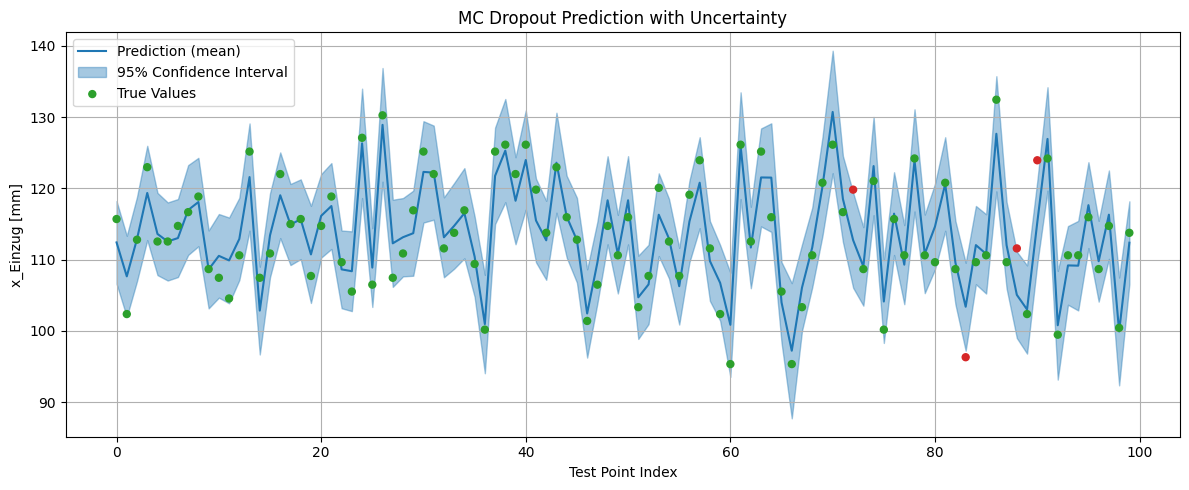

In [57]:
#! handling the train data
# Calculate the mean and standard deviation of the predictions on the train data
y_train_pred_mean = y_train_pred_homoscedastic.mean(axis = 0)
y_train_Pred_std = y_train_pred_homoscedastic.std(axis = 0)
print(y_train_pred_mean[:5])
print(y_train[:5])
# Calculate R² score on the train data
r2_train = r2_score(y_train, y_train_pred_mean)
print(f"R² on Train Data: {r2_train:.3f}")

#! handling the test data
# Select a random subset of test data for visualization
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_te), num_points, replace=False)
random_indices.sort()

# Calculate the mean and standard deviation of the predictions on the test data
y_test_pred_mean = y_test_pred_homoscedastic.mean(axis = 0)

epistemic_var = y_test_pred_homoscedastic.var(axis=0)
print(f"Epistemic Variance: {epistemic_var.mean():.6f}")

# Step 2: Addiere aleatorische Varianz (1/tau) wie im Paper
aleatoric_var = 1 / tau
print(f"Aleatoric Variance: {aleatoric_var:.6f}")
total_std = np.sqrt(epistemic_var + aleatoric_var)
print(f"Total Standard Deviation: {total_std.mean():.6f}")

# Ersetze y_test_pred_std durch total_std
y_test_pred_std = total_std

# Calculate R² score for the test data
r2_test = r2_score(y_test_tensor.cpu(), y_test_pred_mean)
print(f"R² on Test Data: {r2_test:.3f}")

# calculate NLL for the test data
ll = (torch.logsumexp(-0.5 * tau * (y_test_tensor.cpu()[None] - y_test_pred_homoscedastic)**2,0)  # calculate log likelihood according to the paper
      -np.log(n_samples) - 0.5 * np.log(2*np.pi) + 0.5 * np.log(tau))
test_ll = ll.mean()  # Mean Log Likelihood
test_ll = test_ll.to('cpu')  # Move to CPU for printing
nll = -test_ll
print(f"Negative Log Likelihood (NLL) on Test Data: {test_ll:.3f}")


# Assign descriptive variable names for MC Dropout mean and standard deviation
mc_mean = y_test_pred_mean.flatten()  # Predicted mean for each test point
mc_std = y_test_pred_std.flatten()    # Predicted standard deviation for uncertainty

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
mc_lower_bound = mc_mean - 2 * mc_std
mc_upper_bound = mc_mean+ 2 * mc_std

print(f'shape of mc_lower_bound {mc_lower_bound.shape} mc_upper_bound {mc_upper_bound.shape}')
# calculate the coverage of the confidence interval
in_interval = (y_test >= mc_lower_bound) & (y_test <= mc_upper_bound)
# number of true
counter = 0
# Print whether each true value is within the confidence interval
for i in in_interval:
    if i:
        counter += 1

print(f"Number of true values within the confidence interval: {counter} out of {len(in_interval)}")

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Check whether each true value from random indices lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval_rand_indi = (y_test[random_indices] >= mc_lower_bound[random_indices]) & (y_test[random_indices] <= mc_upper_bound[random_indices])
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval_rand_indi]

# Create the plot
plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)  # Create an index axis for plotting

# Plot the predicted mean
plt.plot(x_axis, mc_mean[random_indices], label="Prediction (mean)", color='tab:blue')

# Plot the confidence interval as a shaded region
plt.fill_between(x_axis, mc_lower_bound[random_indices], mc_upper_bound[random_indices], alpha=0.4,
                 color='tab:blue', label='95% Confidence Interval')

# Scatter plot of true values with color-coded points based on interval inclusion
plt.scatter(x_axis, y_test_tensor[random_indices].cpu().flatten(), label="True Values", c=colors, s=25, zorder=3)

# Final plot settings
plt.title("MC Dropout Prediction with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Heteroscedastic Hyperparameter Search with Optuna

In [ ]:
import optuna

def objective(trial):
 
    # hyperparameter for sampling with Optuna
    n_layer = trial.suggest_int("n_layer", 2, 4)  # number of hidden layers
    n_neurons = trial.suggest_int("n_neurons", 32, 256, step=32)  # number of neurons in each hidden layer
    do_rate = trial.suggest_float("do_rate", 0.05, 0.5)     # dropout rate 
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)    # learning rate
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256]) 
    
    # decay factor for the number of neurons in each layer
    # e.g. if n_neurons = 256 and n_layer = 3
    # then the hidden_dims will be [256, 128, 64]
    decay = 0.5
    # this creates a list of integers representing the number of neurons in each hidden layer
    hidden_dims = [int(n_neurons * decay**i) for i in range(n_layer)]
    print(f"Hidden dimensions: {hidden_dims}")
        
    # generate the model with the sampled hyperparameters
    # and move it to the device (GPU or CPU)
    model = NN_model.Custom_NN_Model(
        input_dim=X_train_tensor.shape[1],
        hidden_dims=hidden_dims,
        output_dim=1,
        do_rate=do_rate,
        loss_type = 'heteroscedastic'
    ).to(device)

    # AdamW optimizer, where weight decay does not accumulate in the momentum nor variance.
    optimizer = torch.optim.AdamW(params = model.parameters(), lr = lr, weight_decay=0.0001)  

    # DataLoader for batching the data
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # integrate early stopping
    patience = 20  # number of epochs with no improvement after which training will be stopped
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # training the model
    for epoch in range(epochs):
        model.train()
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)  # Move data to the device (GPU or CPU)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            
            loss = NN_model.heteroscedastic_loss(model, X_batch, y_batch)
            loss.backward()
            optimizer.step()
            
        # validation loss calculation after each epoch
        model.eval()
        with torch.no_grad():
            val_loss = NN_model.heteroscedastic_loss(model, X_val_tensor, y_val_tensor)
            
        trial.report(val_loss, step=epoch)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            #print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Best Val Loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}, Best Val Loss: {best_val_loss:.4f}")
                break
    
    return val_loss


In [79]:
from optuna.trial import TrialState

# define the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# number of epochs for training
epochs = 500

# create a study object for Optuna
study = optuna.create_study(
    #study_name="MC_Dropout_Optuna_Network_architecture",
    #storage="sqlite:///mc_dropout_study.db",                    # Use SQLite database to store the
    #load_if_exists=True,                                        # load the study if it already exists
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),                       #TPE (Tree-structured Parzen Estimator) sampler by default
    pruner=optuna.pruners.MedianPruner(        
        n_startup_trials=10,                                    # Number of trials to run before pruning starts
        n_warmup_steps=5                                        # Number of warmup steps before pruning starts)
    )
)

# move the tensors to the device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

# optimize the objective function with Optuna
# timeout=None means no time limit for the optimization, all trials will be run
study.optimize(objective, n_trials=100, timeout=None, n_jobs=1, show_progress_bar=True)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-07-13 14:39:19,363] A new study created in memory with name: no-name-7a7a5e4e-9a2d-443b-961a-ed473146345b


Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden dimensions: [224, 112]


Best trial: 0. Best value: 2.48096:   1%|          | 1/100 [00:56<1:33:05, 56.42s/it]

Early stopping at epoch 95, Best Val Loss: 2.3852
[I 2025-07-13 14:40:15,809] Trial 0 finished with value: 2.4809603691101074 and parameters: {'n_layer': 2, 'n_neurons': 224, 'do_rate': 0.29459183072478223, 'lr': 0.003911184157560036, 'batch_size': 256}. Best is trial 0 with value: 2.4809603691101074.
Hidden dimensions: [224, 112]


Best trial: 1. Best value: 2.31485:   2%|▏         | 2/100 [04:38<4:10:56, 153.64s/it]

Early stopping at epoch 241, Best Val Loss: 2.2745
[I 2025-07-13 14:43:57,503] Trial 1 finished with value: 2.3148458003997803 and parameters: {'n_layer': 2, 'n_neurons': 224, 'do_rate': 0.42253385250388165, 'lr': 0.00045904613988270433, 'batch_size': 128}. Best is trial 1 with value: 2.3148458003997803.
Hidden dimensions: [96, 48]


Best trial: 1. Best value: 2.31485:   3%|▎         | 3/100 [13:57<9:07:43, 338.79s/it]

Early stopping at epoch 360, Best Val Loss: 2.3936
[I 2025-07-13 14:53:16,637] Trial 2 finished with value: 2.4069201946258545 and parameters: {'n_layer': 2, 'n_neurons': 96, 'do_rate': 0.2708811446684637, 'lr': 0.00014030881420282732, 'batch_size': 64}. Best is trial 1 with value: 2.3148458003997803.
Hidden dimensions: [32, 16, 8, 4]


Best trial: 1. Best value: 2.31485:   4%|▍         | 4/100 [15:39<6:32:46, 245.49s/it]

Early stopping at epoch 53, Best Val Loss: 3.5052
[I 2025-07-13 14:54:59,086] Trial 3 finished with value: 6.230087757110596 and parameters: {'n_layer': 4, 'n_neurons': 32, 'do_rate': 0.29042324245057594, 'lr': 0.0017302037715791713, 'batch_size': 64}. Best is trial 1 with value: 2.3148458003997803.
Hidden dimensions: [128, 64, 32, 16]


Best trial: 1. Best value: 2.31485:   5%|▌         | 5/100 [16:20<4:31:43, 171.62s/it]

Early stopping at epoch 21, Best Val Loss: 7.9497
[I 2025-07-13 14:55:39,707] Trial 4 finished with value: 8.222805976867676 and parameters: {'n_layer': 4, 'n_neurons': 128, 'do_rate': 0.48785550524101406, 'lr': 0.0003295612873106311, 'batch_size': 64}. Best is trial 1 with value: 2.3148458003997803.
Hidden dimensions: [64, 32, 16, 8]


Best trial: 1. Best value: 2.31485:   6%|▌         | 6/100 [16:35<3:05:34, 118.46s/it]

Early stopping at epoch 23, Best Val Loss: 6.0233
[I 2025-07-13 14:55:54,974] Trial 5 finished with value: 14.067634582519531 and parameters: {'n_layer': 4, 'n_neurons': 64, 'do_rate': 0.4950880032191614, 'lr': 0.00029051624335490534, 'batch_size': 256}. Best is trial 1 with value: 2.3148458003997803.
Hidden dimensions: [256, 128, 64]


Best trial: 1. Best value: 2.31485:   7%|▋         | 7/100 [17:52<2:42:38, 104.93s/it]

Early stopping at epoch 44, Best Val Loss: 2.6510
[I 2025-07-13 14:57:12,068] Trial 6 finished with value: 4.651050567626953 and parameters: {'n_layer': 3, 'n_neurons': 256, 'do_rate': 0.13465451688719077, 'lr': 0.005352361137937174, 'batch_size': 64}. Best is trial 1 with value: 2.3148458003997803.
Hidden dimensions: [32, 16, 8, 4]


Best trial: 1. Best value: 2.31485:   8%|▊         | 8/100 [18:18<2:02:14, 79.72s/it] 

Early stopping at epoch 24, Best Val Loss: 6.0169
[I 2025-07-13 14:57:37,801] Trial 7 finished with value: 8.254136085510254 and parameters: {'n_layer': 4, 'n_neurons': 32, 'do_rate': 0.16657437988836132, 'lr': 0.00030240734067462564, 'batch_size': 128}. Best is trial 1 with value: 2.3148458003997803.
Hidden dimensions: [256, 128, 64]


Best trial: 1. Best value: 2.31485:   9%|▉         | 9/100 [22:52<3:32:58, 140.43s/it]

Early stopping at epoch 157, Best Val Loss: 2.2571
[I 2025-07-13 15:02:11,716] Trial 8 finished with value: 2.324489116668701 and parameters: {'n_layer': 3, 'n_neurons': 256, 'do_rate': 0.29388670968683206, 'lr': 0.0004239509909020346, 'batch_size': 64}. Best is trial 1 with value: 2.3148458003997803.
Hidden dimensions: [96, 48, 24, 12]


Best trial: 1. Best value: 2.31485:  10%|█         | 10/100 [23:32<2:44:19, 109.55s/it]

Early stopping at epoch 21, Best Val Loss: 5.9848
[I 2025-07-13 15:02:52,108] Trial 9 finished with value: 8.752713203430176 and parameters: {'n_layer': 4, 'n_neurons': 96, 'do_rate': 0.3688384591704505, 'lr': 0.0002834152558062907, 'batch_size': 64}. Best is trial 1 with value: 2.3148458003997803.
Hidden dimensions: [192, 96]


Best trial: 1. Best value: 2.31485:  11%|█         | 11/100 [24:21<2:14:41, 90.80s/it] 

[I 2025-07-13 15:03:40,411] Trial 10 pruned. 
Hidden dimensions: [192, 96, 48]


Best trial: 1. Best value: 2.31485:  12%|█▏        | 12/100 [24:45<1:43:46, 70.75s/it]

[I 2025-07-13 15:04:05,317] Trial 11 pruned. 
Hidden dimensions: [256, 128, 64]


Best trial: 12. Best value: 2.23261:  13%|█▎        | 13/100 [27:02<2:11:41, 90.82s/it]

Early stopping at epoch 138, Best Val Loss: 2.2208
[I 2025-07-13 15:06:22,317] Trial 12 finished with value: 2.2326149940490723 and parameters: {'n_layer': 3, 'n_neurons': 256, 'do_rate': 0.21937222164443507, 'lr': 0.0016448148026648403, 'batch_size': 128}. Best is trial 12 with value: 2.2326149940490723.
Hidden dimensions: [192, 96, 48]


Best trial: 12. Best value: 2.23261:  14%|█▍        | 14/100 [27:29<1:42:18, 71.38s/it]

[I 2025-07-13 15:06:48,774] Trial 13 pruned. 
Hidden dimensions: [224, 112]


Best trial: 14. Best value: 1.87419:  15%|█▌        | 15/100 [31:01<2:41:02, 113.68s/it]

Early stopping at epoch 239, Best Val Loss: 1.7736
[I 2025-07-13 15:10:20,483] Trial 14 finished with value: 1.8741942644119263 and parameters: {'n_layer': 2, 'n_neurons': 224, 'do_rate': 0.22544418982465303, 'lr': 0.002343595968161641, 'batch_size': 128}. Best is trial 14 with value: 1.8741942644119263.
Hidden dimensions: [160, 80]


Best trial: 14. Best value: 1.87419:  16%|█▌        | 16/100 [31:44<2:09:27, 92.48s/it] 

Early stopping at epoch 49, Best Val Loss: 2.2881
[I 2025-07-13 15:11:03,719] Trial 15 finished with value: 2.4991068840026855 and parameters: {'n_layer': 2, 'n_neurons': 160, 'do_rate': 0.05778280221394003, 'lr': 0.0022482495263520244, 'batch_size': 128}. Best is trial 14 with value: 1.8741942644119263.
Hidden dimensions: [256, 128, 64]


Best trial: 14. Best value: 1.87419:  17%|█▋        | 17/100 [32:07<1:39:11, 71.70s/it]

[I 2025-07-13 15:11:27,102] Trial 16 pruned. 
Hidden dimensions: [224, 112]


Best trial: 17. Best value: 1.76945:  18%|█▊        | 18/100 [34:43<2:12:20, 96.84s/it]

Early stopping at epoch 176, Best Val Loss: 1.6961
[I 2025-07-13 15:14:02,466] Trial 17 finished with value: 1.7694531679153442 and parameters: {'n_layer': 2, 'n_neurons': 224, 'do_rate': 0.08747075502235949, 'lr': 0.00301719390835344, 'batch_size': 128}. Best is trial 17 with value: 1.7694531679153442.
Hidden dimensions: [160, 80]


Best trial: 17. Best value: 1.76945:  19%|█▉        | 19/100 [34:51<1:34:46, 70.21s/it]

[I 2025-07-13 15:14:10,636] Trial 18 pruned. 
Hidden dimensions: [224, 112]


Best trial: 17. Best value: 1.76945:  20%|██        | 20/100 [35:15<1:15:23, 56.54s/it]

Early stopping at epoch 28, Best Val Loss: 2.5511
[I 2025-07-13 15:14:35,318] Trial 19 finished with value: 2.8517520427703857 and parameters: {'n_layer': 2, 'n_neurons': 224, 'do_rate': 0.11333153722138663, 'lr': 0.007922608766683319, 'batch_size': 128}. Best is trial 17 with value: 1.7694531679153442.
Hidden dimensions: [128, 64]


Best trial: 17. Best value: 1.76945:  21%|██        | 21/100 [35:25<56:01, 42.55s/it]  

[I 2025-07-13 15:14:45,266] Trial 20 pruned. 
Hidden dimensions: [224, 112, 56]


Best trial: 17. Best value: 1.76945:  22%|██▏       | 22/100 [35:42<45:14, 34.80s/it]

[I 2025-07-13 15:15:01,980] Trial 21 pruned. 
Hidden dimensions: [256, 128, 64]


Best trial: 17. Best value: 1.76945:  23%|██▎       | 23/100 [35:48<33:32, 26.14s/it]

[I 2025-07-13 15:15:07,934] Trial 22 pruned. 
Hidden dimensions: [192, 96]


Best trial: 23. Best value: 1.65634:  24%|██▍       | 24/100 [39:41<1:51:41, 88.18s/it]

Early stopping at epoch 263, Best Val Loss: 1.6421
[I 2025-07-13 15:19:00,827] Trial 23 finished with value: 1.6563403606414795 and parameters: {'n_layer': 2, 'n_neurons': 192, 'do_rate': 0.3359736148517795, 'lr': 0.004949375518367308, 'batch_size': 128}. Best is trial 23 with value: 1.6563403606414795.
Hidden dimensions: [192, 96]


Best trial: 23. Best value: 1.65634:  25%|██▌       | 25/100 [40:15<1:29:54, 71.93s/it]

[I 2025-07-13 15:19:34,859] Trial 24 pruned. 
Hidden dimensions: [160, 80]


Best trial: 23. Best value: 1.65634:  26%|██▌       | 26/100 [40:19<1:03:27, 51.45s/it]

[I 2025-07-13 15:19:38,510] Trial 25 pruned. 
Hidden dimensions: [224, 112]


Best trial: 23. Best value: 1.65634:  27%|██▋       | 27/100 [40:24<45:45, 37.61s/it]  

[I 2025-07-13 15:19:43,828] Trial 26 pruned. 
Hidden dimensions: [192, 96]


Best trial: 23. Best value: 1.65634:  28%|██▊       | 28/100 [43:21<1:35:19, 79.44s/it]

Early stopping at epoch 198, Best Val Loss: 1.7140
[I 2025-07-13 15:22:40,889] Trial 27 finished with value: 1.7366036176681519 and parameters: {'n_layer': 2, 'n_neurons': 192, 'do_rate': 0.15756875376300994, 'lr': 0.004085092473799007, 'batch_size': 128}. Best is trial 23 with value: 1.6563403606414795.
Hidden dimensions: [192, 96]


Best trial: 23. Best value: 1.65634:  29%|██▉       | 29/100 [43:42<1:13:09, 61.82s/it]

[I 2025-07-13 15:23:01,602] Trial 28 pruned. 
Hidden dimensions: [160, 80]


Best trial: 23. Best value: 1.65634:  30%|███       | 30/100 [43:46<52:06, 44.67s/it]  

[I 2025-07-13 15:23:06,225] Trial 29 pruned. 
Hidden dimensions: [128, 64]


Best trial: 23. Best value: 1.65634:  31%|███       | 31/100 [43:52<37:48, 32.88s/it]

[I 2025-07-13 15:23:11,605] Trial 30 pruned. 
Hidden dimensions: [224, 112]


Best trial: 23. Best value: 1.65634:  32%|███▏      | 32/100 [44:01<29:09, 25.73s/it]

[I 2025-07-13 15:23:20,672] Trial 31 pruned. 
Hidden dimensions: [224, 112]


Best trial: 23. Best value: 1.65634:  33%|███▎      | 33/100 [44:19<26:15, 23.52s/it]

[I 2025-07-13 15:23:39,006] Trial 32 pruned. 
Hidden dimensions: [192, 96]


Best trial: 23. Best value: 1.65634:  34%|███▍      | 34/100 [45:51<48:34, 44.16s/it]

Early stopping at epoch 103, Best Val Loss: 1.9497
[I 2025-07-13 15:25:11,353] Trial 33 finished with value: 2.034510374069214 and parameters: {'n_layer': 2, 'n_neurons': 192, 'do_rate': 0.262438983245987, 'lr': 0.006570604769644599, 'batch_size': 128}. Best is trial 23 with value: 1.6563403606414795.
Hidden dimensions: [224, 112]


Best trial: 23. Best value: 1.65634:  35%|███▌      | 35/100 [48:16<1:20:29, 74.30s/it]

Early stopping at epoch 162, Best Val Loss: 1.7907
[I 2025-07-13 15:27:35,983] Trial 34 finished with value: 1.8025165796279907 and parameters: {'n_layer': 2, 'n_neurons': 224, 'do_rate': 0.17009046668460354, 'lr': 0.002966255365670011, 'batch_size': 128}. Best is trial 23 with value: 1.6563403606414795.
Hidden dimensions: [192, 96]


Best trial: 23. Best value: 1.65634:  36%|███▌      | 36/100 [48:36<1:01:49, 57.97s/it]

[I 2025-07-13 15:27:55,830] Trial 35 pruned. 
Hidden dimensions: [160, 80]


Best trial: 23. Best value: 1.65634:  37%|███▋      | 37/100 [48:39<43:42, 41.63s/it]  

[I 2025-07-13 15:27:59,331] Trial 36 pruned. 
Hidden dimensions: [224, 112]


Best trial: 23. Best value: 1.65634:  38%|███▊      | 38/100 [48:45<31:46, 30.76s/it]

[I 2025-07-13 15:28:04,719] Trial 37 pruned. 
Hidden dimensions: [192, 96]


Best trial: 23. Best value: 1.65634:  39%|███▉      | 39/100 [51:52<1:19:02, 77.75s/it]

Early stopping at epoch 120, Best Val Loss: 1.8147
[I 2025-07-13 15:31:12,146] Trial 38 finished with value: 1.8777910470962524 and parameters: {'n_layer': 2, 'n_neurons': 192, 'do_rate': 0.3135562815332944, 'lr': 0.009890209551341527, 'batch_size': 64}. Best is trial 23 with value: 1.6563403606414795.
Hidden dimensions: [256, 128]


Best trial: 23. Best value: 1.65634:  40%|████      | 40/100 [52:32<1:06:13, 66.23s/it]

Early stopping at epoch 44, Best Val Loss: 2.0975
[I 2025-07-13 15:31:51,478] Trial 39 finished with value: 2.1943533420562744 and parameters: {'n_layer': 2, 'n_neurons': 256, 'do_rate': 0.11647249877576088, 'lr': 0.004914540787385634, 'batch_size': 128}. Best is trial 23 with value: 1.6563403606414795.
Hidden dimensions: [224, 112, 56]


Best trial: 23. Best value: 1.65634:  41%|████      | 41/100 [52:53<51:49, 52.71s/it]  

[I 2025-07-13 15:32:12,644] Trial 40 pruned. 
Hidden dimensions: [224, 112]


Best trial: 23. Best value: 1.65634:  42%|████▏     | 42/100 [53:02<38:16, 39.60s/it]

[I 2025-07-13 15:32:21,668] Trial 41 pruned. 
Hidden dimensions: [256, 128]


Best trial: 23. Best value: 1.65634:  43%|████▎     | 43/100 [53:19<31:11, 32.84s/it]

[I 2025-07-13 15:32:38,697] Trial 42 pruned. 
Hidden dimensions: [192, 96]


Best trial: 23. Best value: 1.65634:  44%|████▍     | 44/100 [53:24<22:57, 24.60s/it]

[I 2025-07-13 15:32:44,078] Trial 43 pruned. 
Hidden dimensions: [224, 112]


Best trial: 23. Best value: 1.65634:  45%|████▌     | 45/100 [55:44<54:07, 59.05s/it]

Early stopping at epoch 156, Best Val Loss: 1.7869
[I 2025-07-13 15:35:03,541] Trial 44 finished with value: 1.9010916948318481 and parameters: {'n_layer': 2, 'n_neurons': 224, 'do_rate': 0.16711553134398233, 'lr': 0.0048301729639278375, 'batch_size': 128}. Best is trial 23 with value: 1.6563403606414795.
Hidden dimensions: [256, 128]


Best trial: 23. Best value: 1.65634:  46%|████▌     | 46/100 [55:49<38:40, 42.97s/it]

[I 2025-07-13 15:35:08,975] Trial 45 pruned. 
Hidden dimensions: [96, 48]


Best trial: 23. Best value: 1.65634:  47%|████▋     | 47/100 [56:34<38:30, 43.59s/it]

Early stopping at epoch 29, Best Val Loss: 2.4153
[I 2025-07-13 15:35:54,019] Trial 46 finished with value: 2.636453151702881 and parameters: {'n_layer': 2, 'n_neurons': 96, 'do_rate': 0.07418588331022838, 'lr': 0.0062671730970956996, 'batch_size': 64}. Best is trial 23 with value: 1.6563403606414795.
Hidden dimensions: [224, 112, 56, 28]


Best trial: 23. Best value: 1.65634:  48%|████▊     | 48/100 [56:45<29:19, 33.84s/it]

[I 2025-07-13 15:36:05,109] Trial 47 pruned. 
Hidden dimensions: [192, 96, 48]


Best trial: 23. Best value: 1.65634:  49%|████▉     | 49/100 [56:49<21:08, 24.87s/it]

[I 2025-07-13 15:36:09,024] Trial 48 pruned. 
Hidden dimensions: [224, 112]


Best trial: 23. Best value: 1.65634:  50%|█████     | 50/100 [57:09<19:27, 23.34s/it]

[I 2025-07-13 15:36:28,823] Trial 49 pruned. 
Hidden dimensions: [160, 80]


Best trial: 23. Best value: 1.65634:  51%|█████     | 51/100 [57:14<14:40, 17.97s/it]

[I 2025-07-13 15:36:34,257] Trial 50 pruned. 
Hidden dimensions: [192, 96]


Best trial: 23. Best value: 1.65634:  52%|█████▏    | 52/100 [57:49<18:19, 22.91s/it]

[I 2025-07-13 15:37:08,689] Trial 51 pruned. 
Hidden dimensions: [192, 96]


Best trial: 23. Best value: 1.65634:  53%|█████▎    | 53/100 [58:29<22:02, 28.14s/it]

[I 2025-07-13 15:37:49,038] Trial 52 pruned. 
Hidden dimensions: [192, 96]


Best trial: 23. Best value: 1.65634:  54%|█████▍    | 54/100 [1:00:14<39:12, 51.14s/it]

Early stopping at epoch 67, Best Val Loss: 2.0102
[I 2025-07-13 15:39:33,853] Trial 53 finished with value: 2.3019049167633057 and parameters: {'n_layer': 2, 'n_neurons': 192, 'do_rate': 0.1744356274927286, 'lr': 0.00823785800408047, 'batch_size': 64}. Best is trial 23 with value: 1.6563403606414795.
Hidden dimensions: [256, 128]


Best trial: 23. Best value: 1.65634:  55%|█████▌    | 55/100 [1:03:32<1:11:18, 95.07s/it]

Early stopping at epoch 126, Best Val Loss: 1.7843
[I 2025-07-13 15:42:51,431] Trial 54 finished with value: 1.8392808437347412 and parameters: {'n_layer': 2, 'n_neurons': 256, 'do_rate': 0.3120880665305587, 'lr': 0.0045367297243775135, 'batch_size': 64}. Best is trial 23 with value: 1.6563403606414795.
Hidden dimensions: [256, 128]


Best trial: 23. Best value: 1.65634:  56%|█████▌    | 56/100 [1:08:11<1:50:17, 150.40s/it]

Early stopping at epoch 170, Best Val Loss: 1.6536
[I 2025-07-13 15:47:30,914] Trial 55 finished with value: 1.6896973848342896 and parameters: {'n_layer': 2, 'n_neurons': 256, 'do_rate': 0.2223770314023439, 'lr': 0.004679879441336161, 'batch_size': 64}. Best is trial 23 with value: 1.6563403606414795.
Hidden dimensions: [256, 128]


Best trial: 23. Best value: 1.65634:  57%|█████▋    | 57/100 [1:08:32<1:20:02, 111.68s/it]

[I 2025-07-13 15:47:52,259] Trial 56 pruned. 
Hidden dimensions: [256, 128, 64]


Best trial: 23. Best value: 1.65634:  58%|█████▊    | 58/100 [1:08:52<58:52, 84.12s/it]   

[I 2025-07-13 15:48:12,051] Trial 57 pruned. 
Hidden dimensions: [256, 128]


Best trial: 23. Best value: 1.65634:  59%|█████▉    | 59/100 [1:12:07<1:20:13, 117.40s/it]

Early stopping at epoch 120, Best Val Loss: 1.7740
[I 2025-07-13 15:51:27,137] Trial 58 finished with value: 1.8345874547958374 and parameters: {'n_layer': 2, 'n_neurons': 256, 'do_rate': 0.14555456727622235, 'lr': 0.0032431014255530763, 'batch_size': 64}. Best is trial 23 with value: 1.6563403606414795.
Hidden dimensions: [256, 128]


Best trial: 23. Best value: 1.65634:  60%|██████    | 60/100 [1:13:11<1:07:26, 101.17s/it]

Early stopping at epoch 35, Best Val Loss: 2.2384
[I 2025-07-13 15:52:30,414] Trial 59 finished with value: 2.26895809173584 and parameters: {'n_layer': 2, 'n_neurons': 256, 'do_rate': 0.14754095324810068, 'lr': 0.00328186941101243, 'batch_size': 64}. Best is trial 23 with value: 1.6563403606414795.
Hidden dimensions: [256, 128]


Best trial: 23. Best value: 1.65634:  61%|██████    | 61/100 [1:13:24<48:36, 74.79s/it]   

[I 2025-07-13 15:52:43,650] Trial 60 pruned. 
Hidden dimensions: [256, 128]


Best trial: 23. Best value: 1.65634:  62%|██████▏   | 62/100 [1:14:23<44:23, 70.10s/it]

Early stopping at epoch 29, Best Val Loss: 2.4559
[I 2025-07-13 15:53:42,798] Trial 61 finished with value: 3.5469260215759277 and parameters: {'n_layer': 2, 'n_neurons': 256, 'do_rate': 0.10444972193121575, 'lr': 0.004357337038124427, 'batch_size': 64}. Best is trial 23 with value: 1.6563403606414795.
Hidden dimensions: [256, 128]


Best trial: 23. Best value: 1.65634:  63%|██████▎   | 63/100 [1:18:38<1:17:22, 125.49s/it]

Early stopping at epoch 144, Best Val Loss: 1.7212
[I 2025-07-13 15:57:57,526] Trial 62 finished with value: 1.756596565246582 and parameters: {'n_layer': 2, 'n_neurons': 256, 'do_rate': 0.20317871093853934, 'lr': 0.0035225662576484356, 'batch_size': 64}. Best is trial 23 with value: 1.6563403606414795.
Hidden dimensions: [224, 112]


Best trial: 23. Best value: 1.65634:  64%|██████▍   | 64/100 [1:18:58<56:17, 93.82s/it]   

[I 2025-07-13 15:58:17,461] Trial 63 pruned. 
Hidden dimensions: [256, 128]


Best trial: 23. Best value: 1.65634:  65%|██████▌   | 65/100 [1:19:15<41:18, 70.83s/it]

[I 2025-07-13 15:58:34,638] Trial 64 pruned. 
Hidden dimensions: [64, 32]


Best trial: 23. Best value: 1.65634:  66%|██████▌   | 66/100 [1:19:26<29:58, 52.90s/it]

[I 2025-07-13 15:58:45,703] Trial 65 pruned. 
Hidden dimensions: [224, 112]


Best trial: 23. Best value: 1.65634:  67%|██████▋   | 67/100 [1:19:30<21:05, 38.36s/it]

[I 2025-07-13 15:58:50,146] Trial 66 pruned. 
Hidden dimensions: [256, 128]


Best trial: 23. Best value: 1.65634:  68%|██████▊   | 68/100 [1:19:47<17:00, 31.88s/it]

[I 2025-07-13 15:59:06,914] Trial 67 pruned. 
Hidden dimensions: [224, 112]


Best trial: 23. Best value: 1.65634:  69%|██████▉   | 69/100 [1:20:09<14:59, 29.00s/it]

[I 2025-07-13 15:59:29,191] Trial 68 pruned. 
Hidden dimensions: [256, 128, 64]


Best trial: 23. Best value: 1.65634:  70%|███████   | 70/100 [1:20:22<12:07, 24.24s/it]

[I 2025-07-13 15:59:42,322] Trial 69 pruned. 
Hidden dimensions: [224, 112]


Best trial: 23. Best value: 1.65634:  71%|███████   | 71/100 [1:20:56<13:06, 27.12s/it]

Early stopping at epoch 30, Best Val Loss: 2.4221
[I 2025-07-13 16:00:16,169] Trial 70 finished with value: 2.6288747787475586 and parameters: {'n_layer': 2, 'n_neurons': 224, 'do_rate': 0.0700055315883148, 'lr': 0.0036751646369403896, 'batch_size': 128}. Best is trial 23 with value: 1.6563403606414795.
Hidden dimensions: [256, 128]


Best trial: 23. Best value: 1.65634:  72%|███████▏  | 72/100 [1:21:18<11:54, 25.51s/it]

[I 2025-07-13 16:00:37,906] Trial 71 pruned. 
Hidden dimensions: [256, 128]


Best trial: 23. Best value: 1.65634:  73%|███████▎  | 73/100 [1:26:38<51:15, 113.91s/it]

Early stopping at epoch 142, Best Val Loss: 1.7149
[I 2025-07-13 16:05:58,078] Trial 72 finished with value: 1.8304517269134521 and parameters: {'n_layer': 2, 'n_neurons': 256, 'do_rate': 0.17158879718863734, 'lr': 0.002703899239255729, 'batch_size': 64}. Best is trial 23 with value: 1.6563403606414795.
Hidden dimensions: [256, 128]


Best trial: 23. Best value: 1.65634:  74%|███████▍  | 74/100 [1:26:58<37:07, 85.69s/it] 

[I 2025-07-13 16:06:17,934] Trial 73 pruned. 
Hidden dimensions: [256, 128]


Best trial: 23. Best value: 1.65634:  75%|███████▌  | 75/100 [1:27:20<27:42, 66.50s/it]

[I 2025-07-13 16:06:39,660] Trial 74 pruned. 
Hidden dimensions: [224, 112]


Best trial: 23. Best value: 1.65634:  76%|███████▌  | 76/100 [1:27:38<20:51, 52.16s/it]

[I 2025-07-13 16:06:58,331] Trial 75 pruned. 
Hidden dimensions: [256, 128]


Best trial: 23. Best value: 1.65634:  77%|███████▋  | 77/100 [1:29:03<23:43, 61.88s/it]

Early stopping at epoch 72, Best Val Loss: 2.1603
[I 2025-07-13 16:08:22,915] Trial 76 finished with value: 2.292527198791504 and parameters: {'n_layer': 2, 'n_neurons': 256, 'do_rate': 0.12639541393154577, 'lr': 0.005988285016975838, 'batch_size': 128}. Best is trial 23 with value: 1.6563403606414795.
Hidden dimensions: [224, 112, 56, 28]


Best trial: 23. Best value: 1.65634:  78%|███████▊  | 78/100 [1:29:10<16:42, 45.55s/it]

[I 2025-07-13 16:08:30,357] Trial 77 pruned. 
Hidden dimensions: [160, 80]


Best trial: 23. Best value: 1.65634:  79%|███████▉  | 79/100 [1:29:18<11:59, 34.25s/it]

[I 2025-07-13 16:08:38,237] Trial 78 pruned. 
Hidden dimensions: [256, 128]


Best trial: 23. Best value: 1.65634:  80%|████████  | 80/100 [1:30:59<18:05, 54.29s/it]

[I 2025-07-13 16:10:19,303] Trial 79 pruned. 
Hidden dimensions: [192, 96]


Best trial: 23. Best value: 1.65634:  81%|████████  | 81/100 [1:31:06<12:41, 40.10s/it]

[I 2025-07-13 16:10:26,278] Trial 80 pruned. 
Hidden dimensions: [256, 128]


Best trial: 81. Best value: 1.65223:  82%|████████▏ | 82/100 [1:38:21<47:33, 158.54s/it]

Early stopping at epoch 196, Best Val Loss: 1.6400
[I 2025-07-13 16:17:41,176] Trial 81 finished with value: 1.6522330045700073 and parameters: {'n_layer': 2, 'n_neurons': 256, 'do_rate': 0.26992510108950274, 'lr': 0.004172847065911164, 'batch_size': 64}. Best is trial 81 with value: 1.6522330045700073.
Hidden dimensions: [256, 128]


Best trial: 81. Best value: 1.65223:  83%|████████▎ | 83/100 [1:43:21<56:54, 200.86s/it]

Early stopping at epoch 140, Best Val Loss: 1.7040
[I 2025-07-13 16:22:40,808] Trial 82 finished with value: 1.8014155626296997 and parameters: {'n_layer': 2, 'n_neurons': 256, 'do_rate': 0.15636321393573882, 'lr': 0.003521183664736017, 'batch_size': 64}. Best is trial 81 with value: 1.6522330045700073.
Hidden dimensions: [224, 112]


Best trial: 81. Best value: 1.65223:  84%|████████▍ | 84/100 [1:43:32<38:24, 144.05s/it]

[I 2025-07-13 16:22:52,272] Trial 83 pruned. 
Hidden dimensions: [256, 128]


Best trial: 81. Best value: 1.65223:  85%|████████▌ | 85/100 [1:49:02<49:54, 199.63s/it]

Early stopping at epoch 153, Best Val Loss: 1.7191
[I 2025-07-13 16:28:21,609] Trial 84 finished with value: 1.8744759559631348 and parameters: {'n_layer': 2, 'n_neurons': 256, 'do_rate': 0.24584141649188987, 'lr': 0.002905192561646606, 'batch_size': 64}. Best is trial 81 with value: 1.6522330045700073.
Hidden dimensions: [224, 112]


Best trial: 81. Best value: 1.65223:  86%|████████▌ | 86/100 [1:49:24<34:11, 146.57s/it]

[I 2025-07-13 16:28:44,364] Trial 85 pruned. 
Hidden dimensions: [256, 128]


Best trial: 81. Best value: 1.65223:  87%|████████▋ | 87/100 [1:49:32<22:45, 105.00s/it]

[I 2025-07-13 16:28:52,380] Trial 86 pruned. 
Hidden dimensions: [256, 128]


Best trial: 81. Best value: 1.65223:  88%|████████▊ | 88/100 [1:51:33<21:54, 109.53s/it]

Early stopping at epoch 60, Best Val Loss: 2.0329
[I 2025-07-13 16:30:52,472] Trial 87 finished with value: 3.6268694400787354 and parameters: {'n_layer': 2, 'n_neurons': 256, 'do_rate': 0.15791056930193292, 'lr': 0.007088765690841187, 'batch_size': 64}. Best is trial 81 with value: 1.6522330045700073.
Hidden dimensions: [224, 112]


Best trial: 81. Best value: 1.65223:  89%|████████▉ | 89/100 [1:51:40<14:28, 78.92s/it] 

[I 2025-07-13 16:30:59,962] Trial 88 pruned. 
Hidden dimensions: [128, 64]


Best trial: 81. Best value: 1.65223:  90%|█████████ | 90/100 [1:51:47<09:33, 57.35s/it]

[I 2025-07-13 16:31:06,979] Trial 89 pruned. 
Hidden dimensions: [224, 112]


Best trial: 81. Best value: 1.65223:  91%|█████████ | 91/100 [1:52:54<09:01, 60.16s/it]

Early stopping at epoch 29, Best Val Loss: 2.4327
[I 2025-07-13 16:32:13,684] Trial 90 finished with value: 3.3562724590301514 and parameters: {'n_layer': 2, 'n_neurons': 224, 'do_rate': 0.10623346882447045, 'lr': 0.004394961059940052, 'batch_size': 64}. Best is trial 81 with value: 1.6522330045700073.
Hidden dimensions: [256, 128]


Best trial: 81. Best value: 1.65223:  92%|█████████▏| 92/100 [1:53:06<06:06, 45.80s/it]

[I 2025-07-13 16:32:25,986] Trial 91 pruned. 
Hidden dimensions: [256, 128]


Best trial: 81. Best value: 1.65223:  93%|█████████▎| 93/100 [1:57:13<12:22, 106.11s/it]

Early stopping at epoch 131, Best Val Loss: 1.7408
[I 2025-07-13 16:36:32,812] Trial 92 finished with value: 1.9488906860351562 and parameters: {'n_layer': 2, 'n_neurons': 256, 'do_rate': 0.12979859220699924, 'lr': 0.0029293191070540524, 'batch_size': 64}. Best is trial 81 with value: 1.6522330045700073.
Hidden dimensions: [256, 128]


Best trial: 81. Best value: 1.65223:  94%|█████████▍| 94/100 [2:03:23<18:30, 185.15s/it]

Early stopping at epoch 158, Best Val Loss: 1.7081
[I 2025-07-13 16:42:42,389] Trial 93 finished with value: 1.855399250984192 and parameters: {'n_layer': 2, 'n_neurons': 256, 'do_rate': 0.1544024983036472, 'lr': 0.002342547742169264, 'batch_size': 64}. Best is trial 81 with value: 1.6522330045700073.
Hidden dimensions: [256, 128]


Best trial: 81. Best value: 1.65223:  95%|█████████▌| 95/100 [2:03:34<11:04, 132.91s/it]

[I 2025-07-13 16:42:53,404] Trial 94 pruned. 
Hidden dimensions: [256, 128]


Best trial: 81. Best value: 1.65223:  96%|█████████▌| 96/100 [2:08:28<12:04, 181.23s/it]

Early stopping at epoch 128, Best Val Loss: 1.7313
[I 2025-07-13 16:47:47,402] Trial 95 finished with value: 1.7523994445800781 and parameters: {'n_layer': 2, 'n_neurons': 256, 'do_rate': 0.19914998876682893, 'lr': 0.006277888201425416, 'batch_size': 64}. Best is trial 81 with value: 1.6522330045700073.
Hidden dimensions: [256, 128]


Best trial: 81. Best value: 1.65223:  97%|█████████▋| 97/100 [2:08:40<06:31, 130.51s/it]

[I 2025-07-13 16:47:59,537] Trial 96 pruned. 
Hidden dimensions: [192, 96]


Best trial: 81. Best value: 1.65223:  98%|█████████▊| 98/100 [2:08:52<03:10, 95.08s/it] 

[I 2025-07-13 16:48:11,963] Trial 97 pruned. 
Hidden dimensions: [224, 112]


Best trial: 81. Best value: 1.65223:  99%|█████████▉| 99/100 [2:09:09<01:11, 71.61s/it]

[I 2025-07-13 16:48:28,809] Trial 98 pruned. 
Hidden dimensions: [32, 16]


Best trial: 81. Best value: 1.65223: 100%|██████████| 100/100 [2:09:15<00:00, 77.56s/it]

[I 2025-07-13 16:48:35,309] Trial 99 pruned. 
Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  59
  Number of complete trials:  41
Best trial:
  Value:  1.6522330045700073
  Params: 
    n_layer: 2
    n_neurons: 256
    do_rate: 0.26992510108950274
    lr: 0.004172847065911164
    batch_size: 64


Heteroscedastic Implementation

In [ ]:
import NN_model
# selcet Device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move training and val data  to device
X_train_tensor = X_train_tensor.to(device)  
X_val_tensor = X_val_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
# Create heteroscedastic model instance with best parameters and move to device
model_heteroscedastic = NN_model.Custom_NN_Model(input_dim=X_train.shape[1], hidden_dims=[256,  64,  16], output_dim=1, do_rate=0.26992510108950274, loss_type = 'heteroscedastic').to(device)  # Create model instance and move to device
print(f"Model: {model_heteroscedastic}")
# Train the model with the best parameters
optimizer_heteroscedastic = torch.optim.AdamW(params=model_heteroscedastic.parameters(), lr=0.004172847065911164, weight_decay=0.0001)  # Use AdamW optimizer with specified learning rate and weight decay
tr_model_heteroscedastic = NN_model.train_model(model_heteroscedastic, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, batch_size=64, n_epochs=1000, optimizer= optimizer_heteroscedastic, patience=50, loss_type='heteroscedastic')

Using device: cpu
Model: Custom_NN_Model(
  (hidden_layers): Sequential(
    (0): Linear(in_features=37, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.26992510108950274, inplace=False)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.26992510108950274, inplace=False)
    (6): Linear(in_features=64, out_features=16, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.26992510108950274, inplace=False)
  )
  (mean_layer): Linear(in_features=16, out_features=1, bias=True)
  (var_layer): Linear(in_features=16, out_features=1, bias=True)
)
Epoch 1/1000, Train Loss: 67.0087, Val Loss: 7.7284, Best Val Loss: 7.7284
Epoch 2/1000, Train Loss: 7.9367, Val Loss: 6.6139, Best Val Loss: 6.6139
Epoch 3/1000, Train Loss: 7.6892, Val Loss: 6.1570, Best Val Loss: 6.1570
Epoch 4/1000, Train Loss: 7.2936, Val Loss: 5.4798, Best Val Loss: 5.4798


KeyboardInterrupt: 

Make Predictions

In [22]:
# inference with multiple forward passes
# keep the model in training mode to keep dropout active
tr_model_heteroscedastic.train()
tr_model_heteroscedastic.to('cpu')  # Ensure the model is on the correct device
X_tr = X_train_tensor.to('cpu')  # Ensure the input data is on the correct device
X_te = X_test_tensor.to('cpu')  # Ensure the test data is on the correct device
# Number of stochastic forward passes for MC Dropout
n_samples = 250

# Make multiple stochastic predictions (MC Dropout) on the train data
y_train_pred_heteroscedastic_mean = []
y_train_pred_heteroscedastic_var= []

for i in range(n_samples):
    mean, log_var = tr_model_heteroscedastic(X_tr)
    y_train_pred_heteroscedastic_mean.append(mean.detach().numpy())
    y_train_pred_heteroscedastic_var.append(torch.exp(log_var).detach().numpy())

# Make multiple stochastic predictions (MC Dropout) on the test data
y_test_pred_heteroscedastic_mean = []
y_test_pred_heteroscedastic_var = []
for i in range(n_samples):
    mean, log_var = tr_model_heteroscedastic(X_te)
    y_test_pred_heteroscedastic_mean.append(mean.detach().numpy())
    y_test_pred_heteroscedastic_var.append(torch.exp(log_var).detach().numpy())

(31206, 1)
[[114.72568]
 [108.77241]
 [121.34   ]
 [124.50674]
 [111.15498]]
[114.7258 106.48   121.0372 129.2826 113.5077]
R² on Train Data: 0.842
Epistemic Variance: 4.489830
Aleatoric Variance: 12.431767
Total Standard Deviation: 3.992525
 y_test std: 7.556901454925537
R² on Test Data: 0.824
Shape of mc_lower_bound: (10403,), mc_upper_bound: (10403,)
Number of true values within the confidence interval: 10237 out of 10403
Coverage: 98.40%


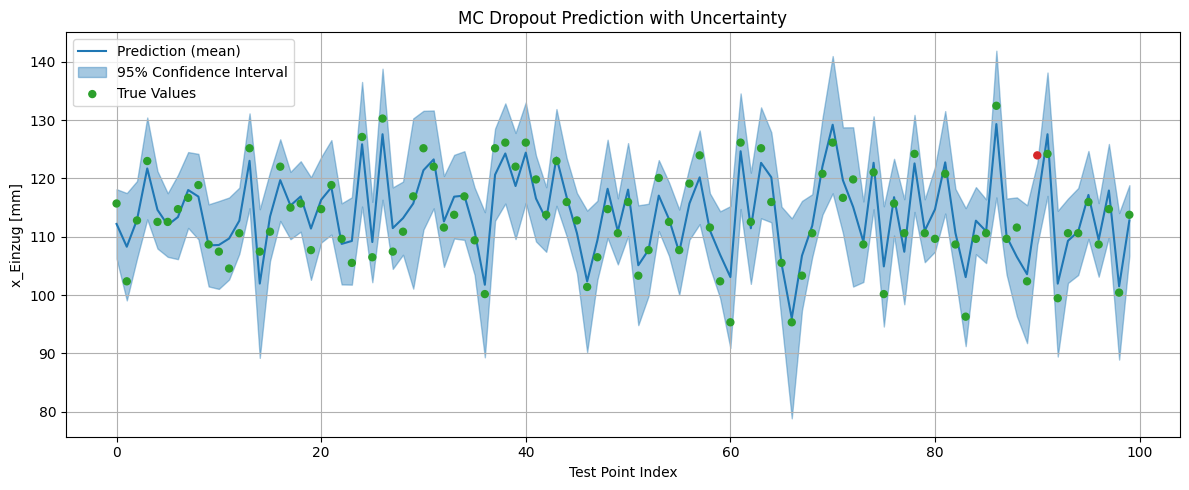

In [24]:
#! handling the train data
# Calculate the mean of the predictions on the train data
mean_train_pred_heteroscedastic = np.mean(y_train_pred_heteroscedastic_mean, axis=0)  # shape: (31206, 1)
print(mean_train_pred_heteroscedastic.shape)
print(mean_train_pred_heteroscedastic[:5])  # Print first 5 predictions for verification
print(y_train[:5])
# Calculate R² score on the train data
r2_train = r2_score(y_train, mean_train_pred_heteroscedastic)
print(f"R² on Train Data: {r2_train:.3f}")

#! handling the test data
# Select a random subset of test data for visualization
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_te), num_points, replace=False)
random_indices.sort()

# Calculate the mean and standard deviation of the predictions on the test data
mean_test_pred_heteroscedastic = np.mean(y_test_pred_heteroscedastic_mean, axis = 0)

# Calculate epistemic
epistemic_var_heteroscedastic = np.var(y_test_pred_heteroscedastic_mean, axis=0)
print(f"Epistemic Variance: {epistemic_var_heteroscedastic.mean():.6f}")

# Calculate aleatoric variance (heteroscedastic)
aleatoric_var_heteroscedastic = np.mean(y_test_pred_heteroscedastic_var, axis=0)
print(f"Aleatoric Variance: {aleatoric_var_heteroscedastic.mean():.6f}")

# Calculate total standard deviation
total_std_heteroscedastic = np.sqrt(epistemic_var_heteroscedastic + aleatoric_var_heteroscedastic)
print(f"Total Standard Deviation: {total_std_heteroscedastic.mean():.6f}")

print(f' y_test std: {y_test_tensor.std().item()}')

# Calculate R² score for the test data
r2_test = r2_score(y_test_tensor.cpu(), mean_test_pred_heteroscedastic)
print(f"R² on Test Data: {r2_test:.3f}")

# Assign descriptive variable names for MC Dropout mean and standard deviation
mc_mean = mean_test_pred_heteroscedastic  # Predicted mean for each test point
mc_std = total_std_heteroscedastic    # Predicted standard deviation for uncertainty

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
mc_lower_bound = (mc_mean - 2 * mc_std).reshape(-1)  # Ensure it is a 1D array
mc_upper_bound = (mc_mean+ 2 * mc_std).reshape(-1)  # Ensure it is a 1D array

print(f"Shape of mc_lower_bound: {mc_lower_bound.shape}, mc_upper_bound: {mc_upper_bound.shape}")

# calculate the coverage of the confidence interval
in_interval = (y_test >= mc_lower_bound) & (y_test <= mc_upper_bound)
# number of true
counter = 0
# Print whether each true value is within the confidence interval
for i in in_interval:
    if i:
        counter += 1

print(f"Number of true values within the confidence interval: {counter} out of {len(in_interval)}")

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Check whether each true value from random indices lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval_rand_indi = (y_test[random_indices] >= mc_lower_bound[random_indices]) & (y_test[random_indices] <= mc_upper_bound[random_indices])
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval_rand_indi]

# Create the plot
plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)  # Create an index axis for plotting

# Plot the predicted mean
plt.plot(x_axis, mc_mean[random_indices], label="Prediction (mean)", color='tab:blue')

# Plot the confidence interval as a shaded region
plt.fill_between(x_axis, mc_lower_bound[random_indices], mc_upper_bound[random_indices], alpha=0.4,
                 color='tab:blue', label='95% Confidence Interval')

# Scatter plot of true values with color-coded points based on interval inclusion
plt.scatter(x_axis, y_test_tensor[random_indices].cpu().flatten(), label="True Values", c=colors, s=25, zorder=3)

# Final plot settings
plt.title("MC Dropout Prediction with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[6873 5130 6255 ...  402 3043 1975]
[ 65.      81.7435  83.9345 ... 127.3499 127.3499 127.3499]
Lowest of mc_lower_bound_full: 89.7096
Highest of mc_upper_bound_full: 141.4293
Highest difference between mc_lower_bound_full and mc_upper_bound_full: 25.7839
Index of highest difference: 3941


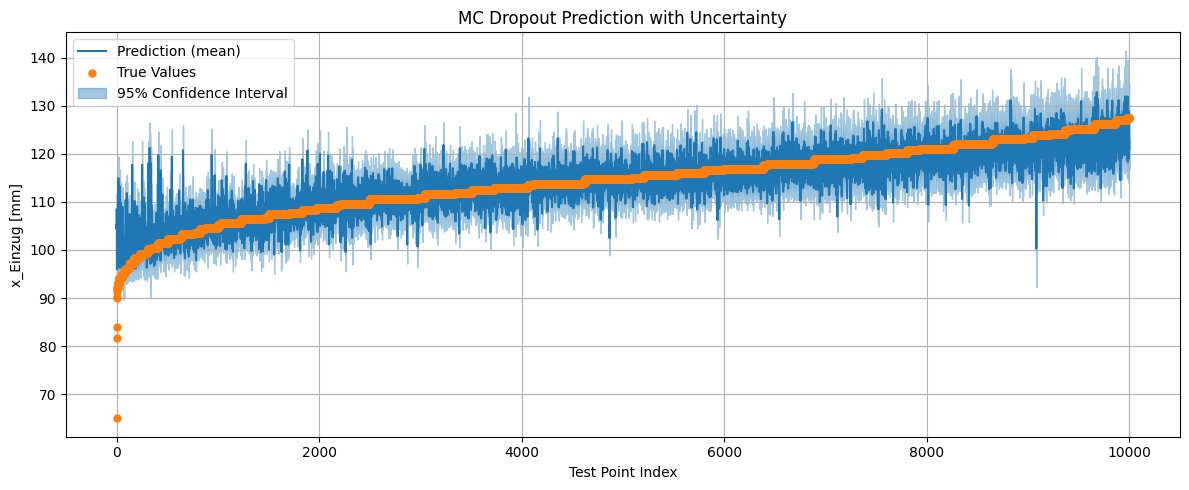

In [64]:
sort_idx = np.argsort(y_test_tensor.cpu().flatten().numpy())
print(sort_idx)
# Sort the predictions and standard deviations for the first 1000 points    
mc_mean_sorted = mc_mean[sort_idx]
mc_std_sorted = mc_std[sort_idx]
y_test_sorted = y_test_tensor.cpu().flatten().numpy()[sort_idx]

n = 10000

mc_mean_sorted = mc_mean_sorted[:n]
mc_std_sorted = mc_std_sorted[:n]   
y_test_sorted = y_test_sorted[:n]

print(y_test_sorted)

mc_lower_bound_full = mc_mean_sorted - 2 * mc_std_sorted
mc_upper_bound_full = mc_mean_sorted + 2 * mc_std_sorted
# print lower of mc_lower_bound_full and highest of mc_upper_bound_full
print(f"Lowest of mc_lower_bound_full: {mc_lower_bound_full.min():.4f}")
print(f"Highest of mc_upper_bound_full: {mc_upper_bound_full.max():.4f}")

#print the highes difference between mc_lower_bound_full and mc_upper_bound_full and the index of the highest difference
diff = mc_upper_bound_full - mc_lower_bound_full
print(f"Highest difference between mc_lower_bound_full and mc_upper_bound_full: {diff.max():.4f}")
print(f"Index of highest difference: {np.argmax(diff)}")

# Create the plot
plt.figure(figsize=(12, 5))
x_axis = np.arange(n)  # Create an index axis for plotting
# Plot the predicted mean
plt.plot(mc_mean_sorted, label="Prediction (mean)", color='tab:blue')

# plot true values for the first 100 points
plt.scatter(x_axis, y_test_sorted, label="True Values", c='tab:orange', s=25, zorder=3)

# Plot the confidence interval as a shaded region
plt.fill_between(x_axis, mc_lower_bound_full, mc_upper_bound_full, alpha=0.4,
                 color='tab:blue', label='95% Confidence Interval')
# Final plot settings
plt.title("MC Dropout Prediction with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()